# Load Libraries

In [1]:
suppressPackageStartupMessages({
    library(gdata)
    library(singlecellmethods)
    library(matrixStats)
    library(data.table)
    library(viridis)
    #library(seaborn)
    library(RColorBrewer)
    library(ComplexHeatmap)
    library(Matrix)
    library(harmony)
    library(uwot)
    library(irlba)
    library(Seurat)
    library(factoextra)
    library(presto) 
    source("//Users/ybaglaen/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/Analysis/utils.R")
    source("//Users/ybaglaen/Box Sync/2017 - Raychaudhuri Lab/Lab Documents/scRNA-DNA GSK/Experiments/UpdatedExperiments/2023-04-03 PTEN-DQB1-FBXO11/Analysis/misc_funcs.R")
    library(tidyverse)
    library(ggpubr)
    library(ggridges)
    library(ggrepel)
})

# Load All libraries. Skip steps below

In [2]:
FlowMatrix <- read_csv("FlowMatrixFinal.csv")

Rows: 6144 Columns: 23
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (12): Well_ID, DNA_cell, RNA_cell, Experiment_Index, Plate, Edited_Index...
dbl (11): PB_CD81, BV605_CD45, BV750_CD45, SSC, FSC, FITC_CD45, PE_CD81, PEC...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
#Load Meta RNA
meta <- read_csv("meta.csv")

Rows: 6144 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): plate, cell, PlateLabel, Condition, DNA_Barcode, ADT_Barcode, sgRN...
dbl  (3): nUMI, nGenes, pctMito

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#Import RNA
exprs <- readMM(file = "exprs.mtx")
colnames(exprs) <- read_csv("exprs_colnames.csv") %>% with(x)
rownames(exprs) <- read_csv("exprs_rownames.csv") %>% with(x)

New names:
• `` -> `...1`
Rows: 6144 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): x
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 36591 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): x
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
#Import ADT
meta_adt_filt <- read_csv("meta_ADT_filt.csv")
counts_adt_filt <- readMM(file = "counts_ADT_filt.mtx")
colnames(counts_adt_filt) <- read_csv("colnames_counts_ADT_filt.csv") %>% with(x)
rownames(counts_adt_filt) <- read_csv("rownames_counts_ADT_filt.csv") %>% with(x)


Rows: 6038 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): plate, cell_adt, PlateLabel, Condition, RNA_Barcode, DNA_Barcode, ...
dbl  (2): nUMI, nGenes

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 6144 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): x
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
New names:
• `` -> `...1`
Rows: 154 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): x
dbl (1): ...1

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE`

In [6]:
#Add DNA
meta_DNA <- read_csv("CD45_RPL8_TYK2_Meta.csv")
alleles_DNA <- read_csv("alleles_DNA.csv")
#Add Meta 
alleles_DNA_meta<- inner_join(alleles_DNA, meta_DNA)

Rows: 16 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): PlateLabel, Condition, RNA_Barcode, DNA_Barcode, ADT_Barcode, sgRNA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 8389 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): DNA_Barcode, Well_ID, Aligned_Sequence
dbl (5): n_deleted, n_inserted, n_mutated, #Reads, %Reads

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(DNA_Barcode)`


# Subset DNA - CD45

In [8]:
#subset for analysis
CD45_alleles_DNA <- filter(alleles_DNA_meta, Condition == "CD45")

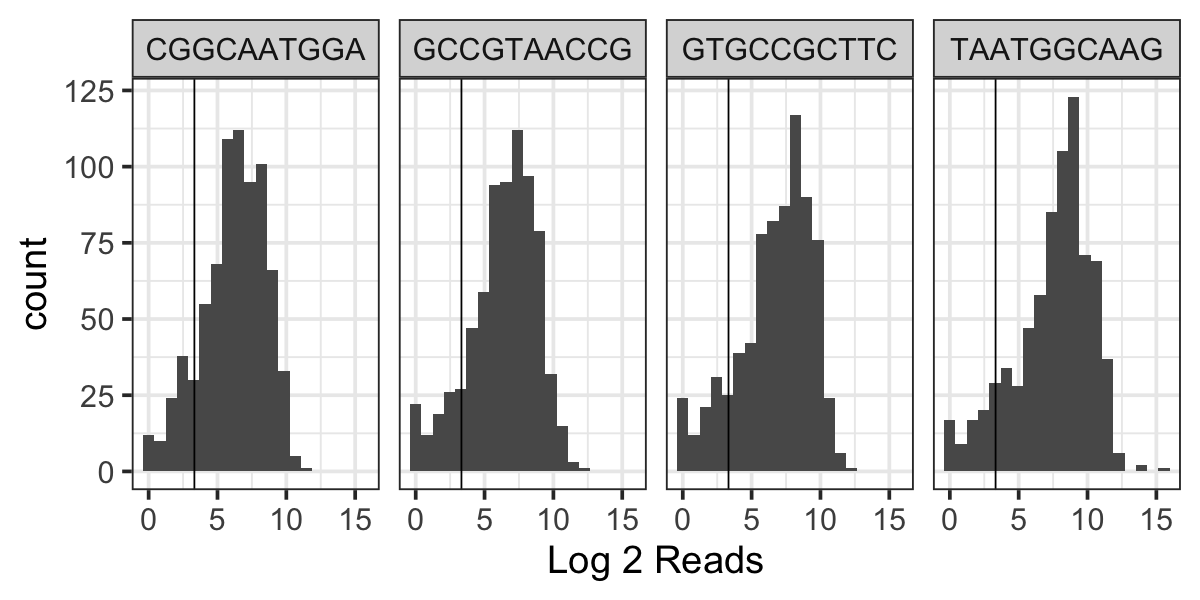

In [16]:
### DNA reads
fig.size(5,10) 
CD45_alleles_DNA %>% ggplot(aes(log2(`#Reads`))) + 
    geom_histogram(bins =20) + theme_gy() + geom_vline(xintercept = log2(10)) + xlab("Log 2 Reads") +
  facet_grid(~DNA_Barcode)



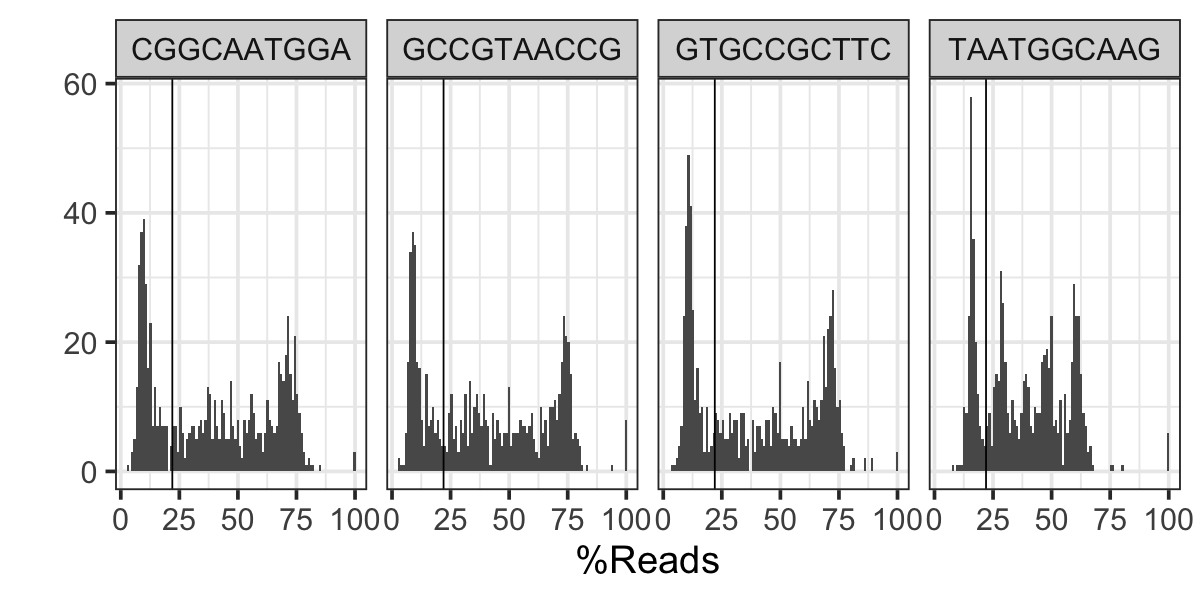

In [18]:
fig.size(5,10) 
CD45_alleles_DNA %>% #filter(`#Reads` > 40) %>%
    ggplot(aes((`%Reads`))) + 
    geom_histogram(bins = 100) + theme_gy() + geom_vline(xintercept = (22)) + 
    xlab("%Reads") + ylab("")+
  facet_grid(~DNA_Barcode)

# DNA Analysis

In [19]:
##Filtering Function and spreading out the two alleles. 
FilterAlleles <- function(matrix, x = 22, y = 40){
test <- matrix %>% 
    dplyr::filter(`%Reads` > x) %>% dplyr::filter(`#Reads` > y) %>% 
    mutate("Allele" = ifelse(duplicated(Plate_Well) == F, "Allele1", "Allele2")) %>% 
    mutate("AlleleReads" = ifelse(duplicated(Plate_Well) == F, "Allele1read", "Allele2read")) %>% 
    spread(AlleleReads, `#Reads`) %>% spread(Allele, Aligned_Sequence)%>% 
    select(Plate_Well, Allele1,  Allele1read, Allele2, Allele2read)

Return <- left_join(drop_na(test[,c(1,2,3)]), drop_na(test[,c(1,4,5)])) %>% 
   mutate("OnlyOneAlleleRecovered" = ifelse(is.na(Allele2) == T, T, F)) %>% 
    mutate("Allele2" = ifelse(is.na(Allele2) == T, Allele1, Allele2)) %>%
    mutate("Allele2read" = ifelse(is.na(Allele2read) == T, Allele1read, Allele2read))    
return(Return)
}

In [20]:
GenotypesFunction <- function(Return){ 
 allele1_mat <- matrix(str_split(Return$Allele1, "", simplify = TRUE), 
        nrow = nrow(Return), byrow = FALSE)
    allele2_mat <- matrix(str_split(Return$Allele2, "", simplify = TRUE), 
        nrow = nrow(Return), byrow = FALSE)
    ref_mat <- matrix(str_split(Return$Reference, "", simplify = TRUE), 
        nrow = nrow(Return), byrow = FALSE)
    Ref <- matrix(paste0(ref_mat, ref_mat), nrow(allele1_mat), 
        ncol(allele1_mat))
    Full <- matrix(paste0(allele1_mat, allele2_mat), nrow(allele1_mat), 
        ncol(allele1_mat))
    Full <- Full %>% apply(2, function(x) {
        if_else(x == "TA", "AT", if_else(x == "GA", "AG", if_else(x == 
            "CA", "AC", if_else(x == "TC", "CT", if_else(x == 
            "GC", "CG", if_else(x == "TG", "GT", if_else(x == 
            "A-", "-A", if_else(x == "T-", "-T", if_else(x == 
            "G-", "-G", if_else(x == "C-", "-C", x))))))))))
    })
    Full <- apply(Full, 1, paste, collapse = "") %>% as.matrix()
    Ref <- apply(Ref, 1, paste, collapse = "") %>% as.matrix
    Output <- as_tibble(cbind(Return$DNA_Barcode, Return$Well_ID, 
        Full, Ref))
    colnames(Output) <- c("DNA_Barcode", "Well", "Alleles", "Reference")
    genotypes_df <- Output %>% dplyr::select(Alleles) %>% unique() %>% 
        tibble::rownames_to_column("genotype")
    Output <- left_join(Output, genotypes_df)
    return(Output)
}


In [21]:
#GenotypeHeatmap2
GenotypeHeatmap2 <- function (matrix, y) 
{
    CRISPRessoDNA_heatmap <- matrix
    CRISPRessoDNA_heatmap <- CRISPRessoDNA_heatmap %>% add_count(genotype) %>% 
        dplyr::rename(count = n)
    CRISPRessoDNA_heatmap <- dplyr::filter(CRISPRessoDNA_heatmap, 
        count > y) %>% arrange(desc(count))

 ALLELES <- apply(matrix(CRISPRessoDNA_heatmap$Alleles), 1, 
        function(x) {
            gsub("(.{2})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(CRISPRessoDNA_heatmap$Alleles[1])/2)
    REF <- apply(matrix(CRISPRessoDNA_heatmap$Reference), 1, 
        function(x) {
            gsub("(.{2})", "\\1 ", x)
        }) %>% str_split_fixed(pattern = " ", n = str_length(CRISPRessoDNA_heatmap$Alleles[1])/2)
x <- copy(ALLELES)
    x[ALLELES == REF] <- "R"
    y <- copy(ALLELES)
    x <- x %>% unique %>% as.data.frame(stringsAsFactors = FALSE) %>% tidyr::gather(position, 
        value) %>% dplyr::mutate(position = gsub("V", 
        "", position))
    rownames(y) <- CRISPRessoDNA_heatmap$genotype

 y <- y %>% unique %>% as.data.frame(stringsAsFactors = FALSE) %>% 
        rownames_to_column("genotypes") %>% tidyr::gather(position, 
        value, -genotypes) %>% dplyr::mutate(position = gsub("V", 
        "", position))
 x <- mutate(x, genotypes = y$genotypes)
   y <- y %>% dplyr::rename(label = value)
    x <- x %>% cbind(y$label)
    x <- mutate(x, Genotype = paste0("G", genotypes))
    z <- y$label %>% str_split_fixed(pattern = "", n = 2)
    colnames(z) <- c("A", "B")
    df <- cbind(z, x) %>% pivot_longer(cols = -c(position, value, 
        `y$label`, Genotype, genotypes), values_to = "allele_value", 
        names_to = "allele")
    return(df)
}


In [22]:
CD45_alleles_DNA_filt <- CD45_alleles_DNA %>% mutate("Plate_Well" = paste0(DNA_Barcode, "_", Well_ID)) %>% 
    FilterAlleles(22,40) 
#Add meta data
CD45_alleles_DNA_filt<- 
  CD45_alleles_DNA_filt %>% separate(Plate_Well, into = c("DNA_Barcode", "Well_ID")) %>% inner_join(meta_DNA)

#Match lenghts of Ref and Allele
CD45_alleles_DNA_filt <- mutate(CD45_alleles_DNA_filt, 
                               Allele1 = str_trunc(Allele1, 180, "right", "")) %>% 
    mutate(Allele2 = str_trunc(Allele2, 180, "right", ""))

#Fix length from P7
CD45_alleles_DNA_filt<- CD45_alleles_DNA_filt %>% 
    mutate("Allele1" = str_trunc(Allele1, 150, "left", ellipsis = "")) %>% 
    mutate("Allele2" = str_trunc(Allele2, 150, "left", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 150, "left", ellipsis = ""))%>% 
    mutate("Allele1" = str_trunc(Allele1, 40, "right", ellipsis = "")) %>% 
    mutate("Allele2" = str_trunc(Allele2, 40, "right", ellipsis = "")) %>% 
    mutate("Reference"= str_trunc(Reference, 40, "right", ellipsis = ""))
#Generate Genotypes
CD45_alleles_DNA_filt_gen <- GenotypesFunction(CD45_alleles_DNA_filt)

Joining with `by = join_by(Plate_Well)`
Joining with `by = join_by(DNA_Barcode)`
Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble
2.0.0.
ℹ Using compatibility `.name_repair`.”
Joining with `by = join_by(Alleles)`


Warning message:
“`as_data_frame()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` (with slightly different semantics) to convert to a tibble, or `as.data.frame()` to
  convert to a data frame.”
Saving 7 x 7 in image


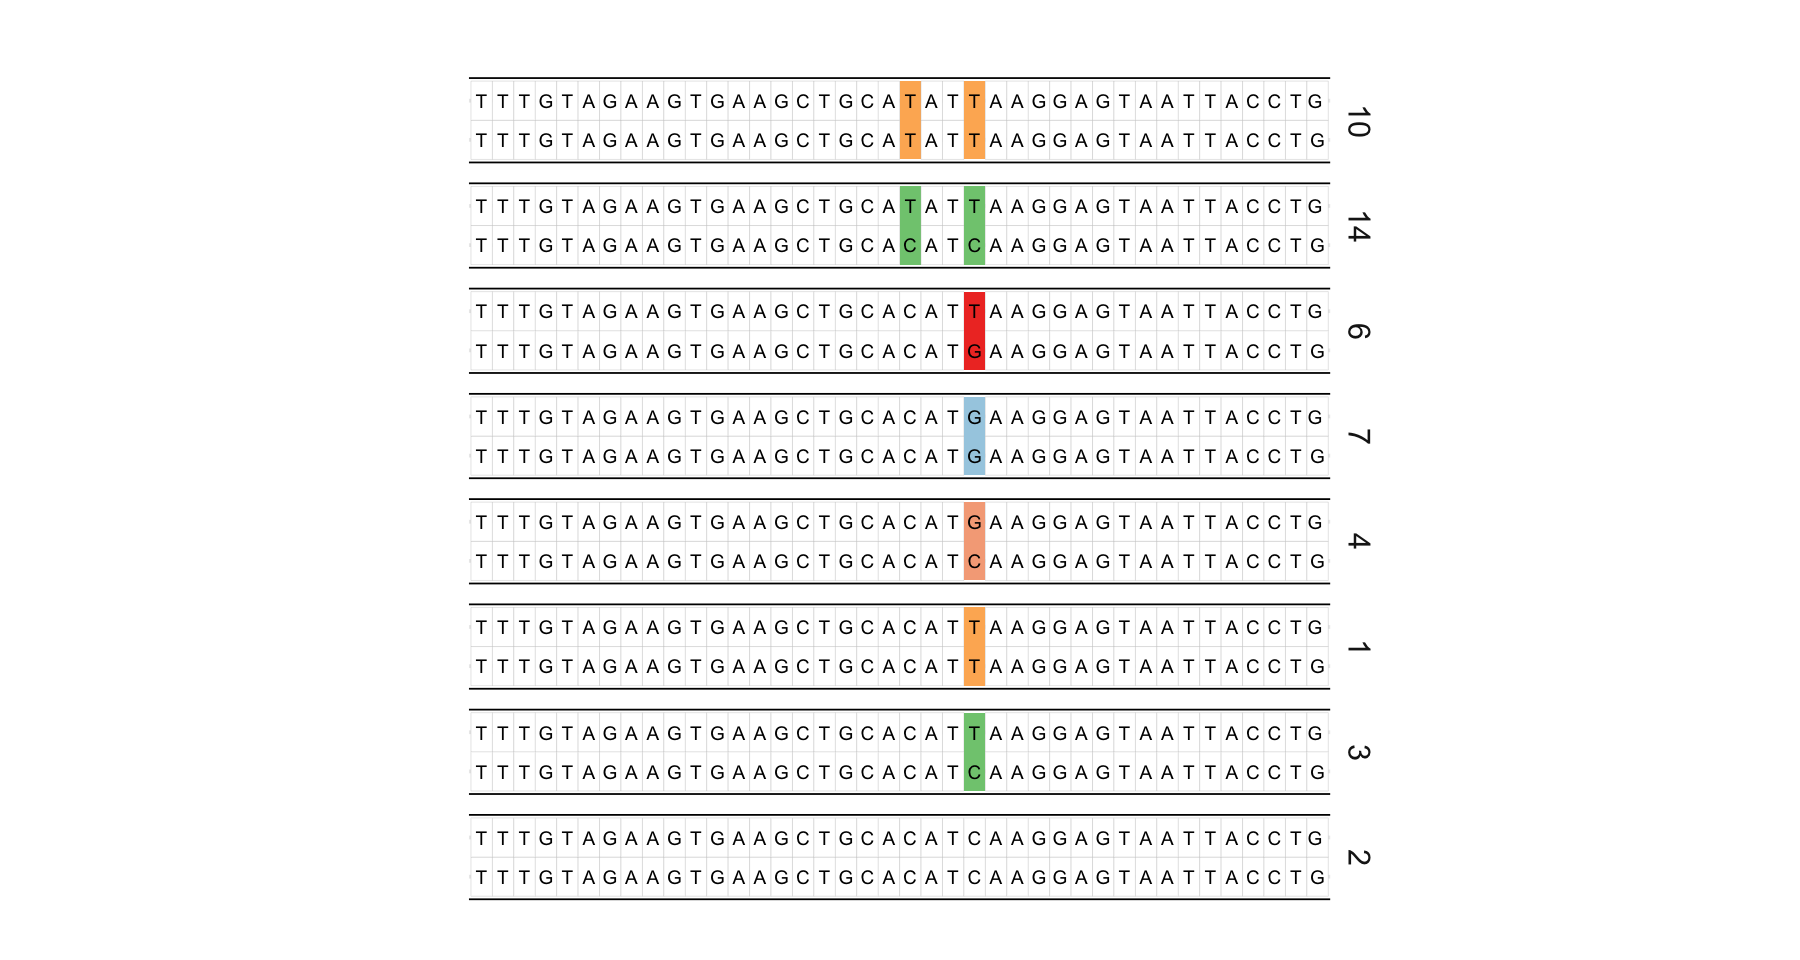

In [23]:
#Defineplotting Order
order <- CD45_alleles_DNA_filt_gen$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)


fig.size(8,15)
df<- GenotypeHeatmap2(CD45_alleles_DNA_filt_gen, 2)
df$Genotype <- factor(df$Genotype, levels = c(paste0("G", 100:1)))

g <-     

g<- df %>% #the number is the filter on genotype 
ggplot(aes(x = reorder(position, as.integer(position)), 
           y = allele, fill = `value`)) + 
    geom_tile(aes(color = value), width=1, height=1) +
        geom_text(data = dplyr::filter(df),
                  aes(label = `allele_value`), angle = 0, size = (4)) + 
        scale_fill_manual(values = 
                    c(R = 'white',
                    CC = "#5194ed", 
                      TT = "#fdb462", 
                      CT = "#7fc97f", 
                      GT = "#ef3b2c",
                      CG = "#f5aa87",
                      GG = "#a6cee3",  
                      AG = "#f5bbba",
                      AA = "#fae1e1",
                     `-A`= "grey90", 
                     `-T` = "grey90", 
                     `-C` = "grey90", 
                     `-G` = "grey90", 
                     `--` ="grey80"))+ 
        scale_color_manual(values = 
                   c(R = 'grey',
                      CC = "NA", 
                      TT = "NA", 
                      CT = "NA", 
                      GT = "NA",
                      CG = "NA",
                      GG = "NA",  
                     AG = "NA"))+ 
     #c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33"))
        ggtitle("") + 
        theme_gy()+
    xlab("")+
    theme(aspect.ratio = 0.1)+ 
    ylab("") +
    theme(axis.text.y = element_text(size = 0, angle = 0, hjust = .5, vjust = .5),
          axis.text.x = element_text(size = 0),
        axis.title.x = element_text(size = 20, angle = 0, hjust = .5, vjust = .5),
        axis.title.y = element_text(size = 20, angle = 90, hjust = .5, vjust = .5),
          axis.ticks.y = element_blank(),
         legend.position = "none") + 
    scale_x_discrete(breaks=NULL) + 
    facet_grid(factor((genotypes), levels = order)~.)+ 
theme(
  strip.background = element_blank(),
  strip.text.x = element_blank(), 
    panel.border=element_blank()

) + 
    annotate(geom = 'segment', y = Inf, yend = Inf, color = 'black', x = -Inf, xend = Inf, linewidth = 1) + 

    annotate(geom = 'segment', y = -Inf, yend = -Inf, color = 'black', x = -Inf, xend = Inf, linewidth = 1)
plot(g)

## save the plot
suppressWarnings({ 
    ggsave(g, filename = "CD45Genotypes.png", device = "png", dpi = 300)
    })

In [ ]:
# Plot distribution of genotypes per person and control category

In [24]:
## Joining genotype data with Flow Data . 
FLOW_DNA_CD45 <- 
CD45_alleles_DNA_filt_gen %>% rename("Well_ID" = Well)%>% 
    inner_join(meta_DNA, by = "DNA_Barcode") %>% 
    inner_join(read_csv("RNA_ADT_Barcodes.csv")) %>% 
    mutate(cell = paste0(RNA_cell, "_", RNA_Barcode)) %>% 
    inner_join(FlowMatrix)%>%  
    add_count(genotype, name = "genotype_count") # Add genotype Count

## Define df for plotting 
test2 <- filter(FLOW_DNA_CD45, genotype_count  > 2)

## Make a table and merge. 
table(test2$genotype, test2$Individual_Index, test2$Edited_Index) %>% 
as.data.frame() %>% rename(Individual_Index = Var2, Edited_Index = Var3, genotype = Var1) %>% 
inner_join( 
test2 %>% group_by(as.factor(Edited_Index), as.factor(Individual_Index), as.factor(genotype)) %>% 
    summarise(mean(FITC_CD45)) %>% rename(Individual_Index = `as.factor(Individual_Index)`, 
                                          Edited_Index = `as.factor(Edited_Index)`, 
                                          genotype = `as.factor(genotype)`)
) %>% head

#Defineplotting Order
order <- test2$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)

Rows: 384 Columns: 2
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Well_ID, RNA_cell

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(Well_ID)`
Joining with `by = join_by(DNA_Barcode, Well_ID, PlateLabel, RNA_Barcode, ADT_Barcode, RNA_cell, cell)`
`summarise()` has grouped output by 'as.factor(Edited_Index)', 'as.factor(Individual_Index)'. You can override
using the `.groups` argument.
Joining with `by = join_by(genotype, Individual_Index, Edited_Index)`


genotype Individual_Index Edited_Index Freq mean(FITC_CD45)
1 2        10020543         Control      43   337.11059      
2 2        10038222         Control      25   284.49194      
3 2        10049338         Control      20   344.31988      
4 1        10020543         Edited       97    85.55547      
5 10       10020543         Edited        2   217.48786      
6 14       10020543         Edited        1   353.85727

`summarise()` has grouped output by 'as.factor(Edited_Index)', 'as.factor(Individual_Index)'. You can override
using the `.groups` argument.
Joining with `by = join_by(genotype, Individual_Index, Edited_Index)`


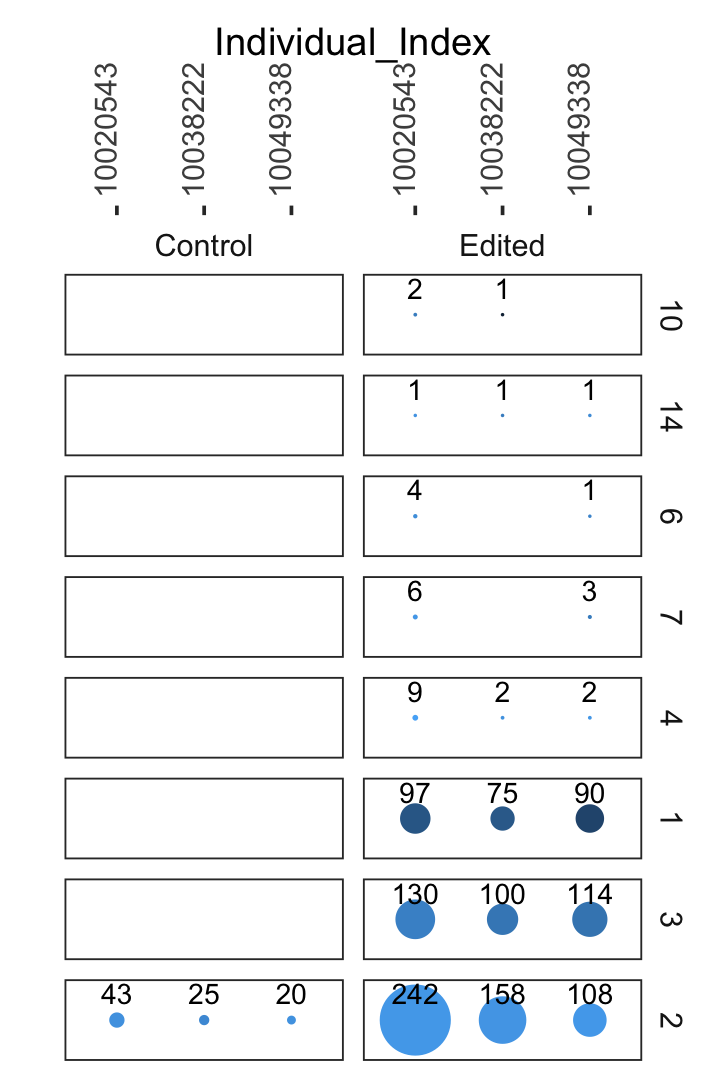

In [25]:
fig.size(9,6)
g <- 

table(test2$genotype, test2$Individual_Index, test2$Edited_Index) %>% 
as.data.frame() %>% rename(Individual_Index = Var2, Edited_Index = Var3, genotype = Var1) %>% 
inner_join( 
test2 %>% group_by(as.factor(Edited_Index), as.factor(Individual_Index), as.factor(genotype)) %>% 
    summarise(mean(FITC_CD45)) %>% rename(Individual_Index = `as.factor(Individual_Index)`, 
                                          Edited_Index = `as.factor(Edited_Index)`, genotype = `as.factor(genotype)`)
)%>% na.omit%>% {
    
    ggplot(., aes(Individual_Index, 
                  fill = log10(`mean(FITC_CD45)`), size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =6, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype), levels = order)~Edited_Index) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        )
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "CD45Genotypes_Counts_FITC_legend.png", device = "png", dpi = 300, width = 6, height = 9)
    })

In [28]:
FLOW_DNA_CD45$DNA_Barcode %>% table

.
CGGCAATGGA GCCGTAACCG GTGCCGCTTC TAATGGCAAG 
       314        312        314        314 

# QC

## RNA QC

In [ ]:
# QC figures

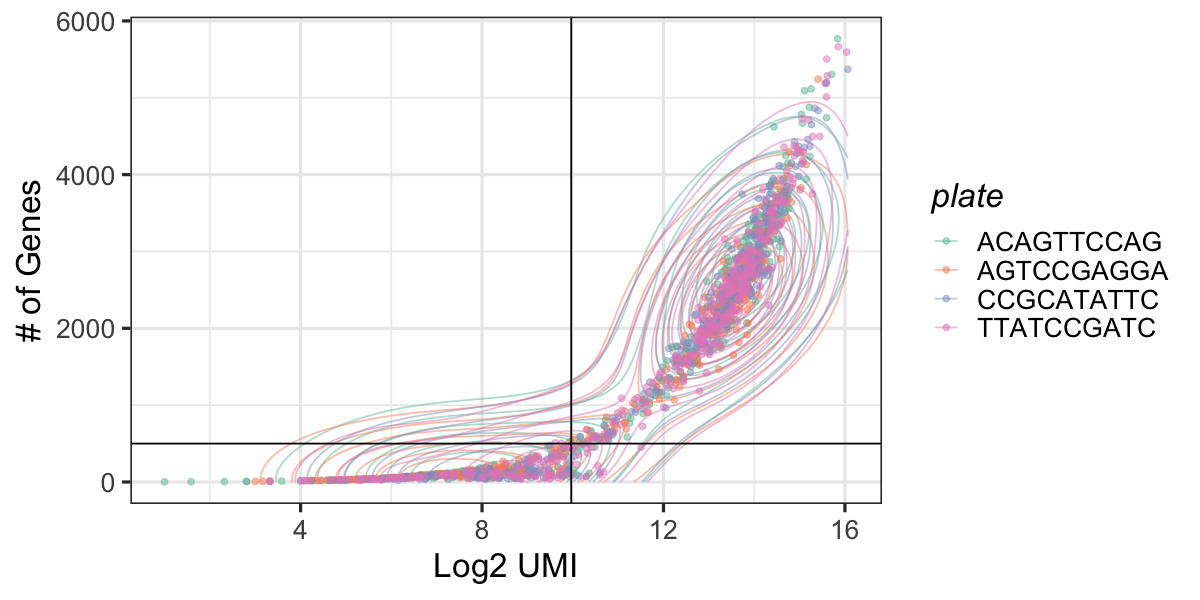

In [141]:
fig.size(5, 10)
ggplot(filter(meta, Condition == "CD45")) +
    geom_density_2d(aes(x=log2(nUMI), y=nGenes, color = plate), alpha = 0.5)+ 
    geom_point(aes(x=log2(nUMI), y=nGenes, color = plate), alpha = 0.5) +
    theme_gy(20) + ylab("# of Genes") + 
    xlab("Log2 UMI") + scale_color_brewer(palette = "Set2") + 
   geom_vline(xintercept = log2(1000))+ 
geom_hline(yintercept = 500)
    

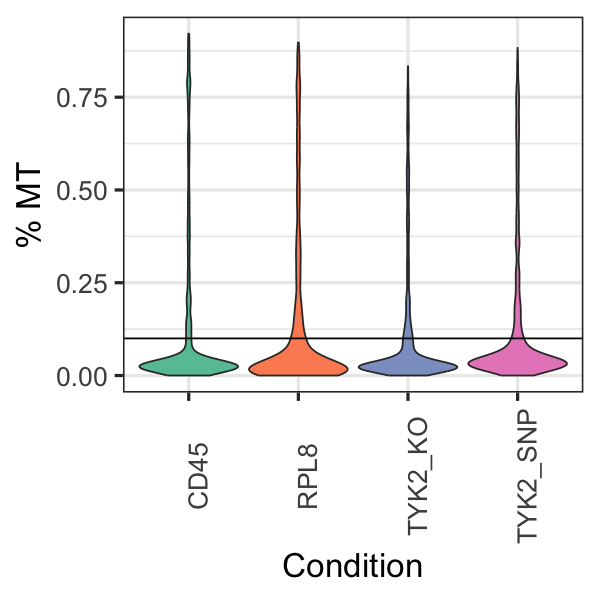

In [142]:
fig.size(5, 5)
meta %>%
ggplot()+
    geom_violin(aes(x = Condition, y = pctMito, fill= Condition), scale = 'width')+
    theme_gy()+
    geom_hline(yintercept = 0.1) + 
    theme_gy(20) + ylab("% MT") + 
    scale_fill_brewer(palette = "Set2")  + 
    theme(legend.position = "none")+
    theme(axis.text.x = element_text(angle = 90), legend.position = "none")

In [18]:
nCells = rowSums(exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

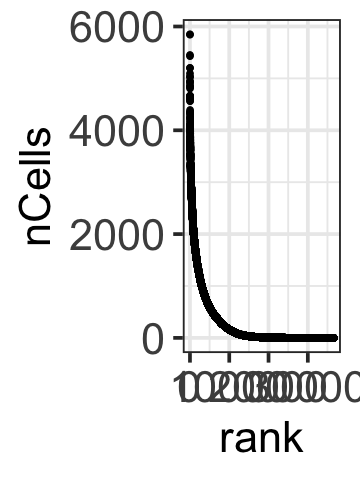

In [20]:
ggplot(gene_qc)+
    geom_point(aes(x = rank, y = nCells))+
    theme_gy()

In [15]:
nUMI_thresh =  1000 #5000 #40
nGene_thresh = 500
pctMito_thresh = 0.1
ncell_thresh = 10

filt_exprs = exprs[rownames(gene_qc %>% filter(nCells > ncell_thresh)), 
                   (meta %>% filter(nUMI > nUMI_thresh, 
                                               nGenes > nGene_thresh, 
                                               pctMito < pctMito_thresh) %>% with(cell))]
filt_meta = filter(meta, cell %in% colnames(filt_exprs))

In [25]:
exprs %>% dim
filt_exprs %>% dim

[1] 36591  6144

[1] 18534  3267

In [149]:
filt_cellcount = (table(meta$Condition) %>% unclass %>% as.data.frame) - 
                (table(filt_meta$Condition) %>% unclass %>% as.data.frame)
filt_cellcount$Condition = rownames(filt_cellcount)

colnames(filt_cellcount)[1] = 'Freq'

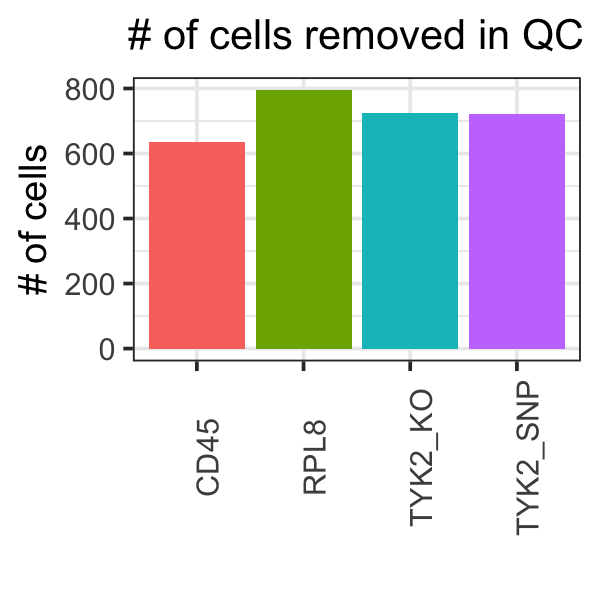

In [150]:
### Number of cells per condition/plate

fig.size(5,5)
ggplot(filt_cellcount)+
    geom_col(aes(y = Freq, x = Condition, fill = Condition))+
    theme_gy()+
    theme(axis.text.x = element_text(angle = 90), legend.position = 'none')+
    xlab('')+
    labs(fill = '')+
    ylab('# of cells')+
    ggtitle('# of cells removed in QC')

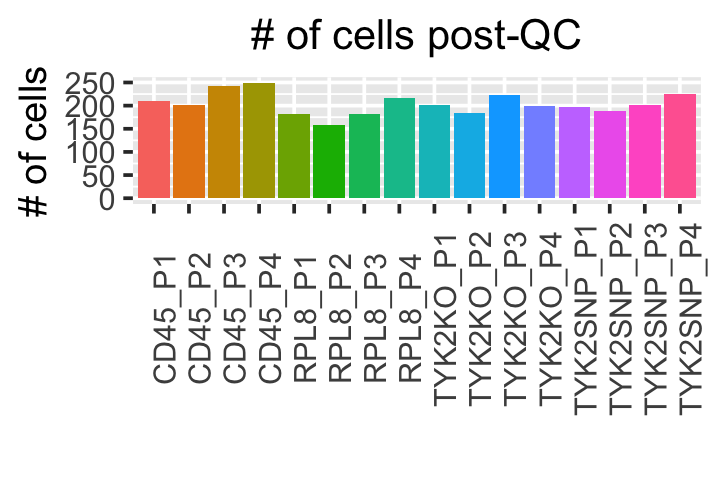

In [151]:
### Number of cells per condition/plate

fig.size(4, 6)
ggplot(table(filt_meta$PlateLabel, filt_meta$PlateLabel) %>% as.data.frame)+
    geom_col(aes(y = Freq, x = Var1, fill = Var2))+
    theme_g()+
    theme(axis.text.x = element_text(angle = 90), legend.position = 'none')+
    xlab('')+
    labs(fill = '')+
    ylab('# of cells')+
    ggtitle('# of cells post-QC')

## ADT QC

In [27]:
counts_ADT_filt <- counts_adt_filt

In [28]:
meta_ADT_filt <- meta_adt_filt

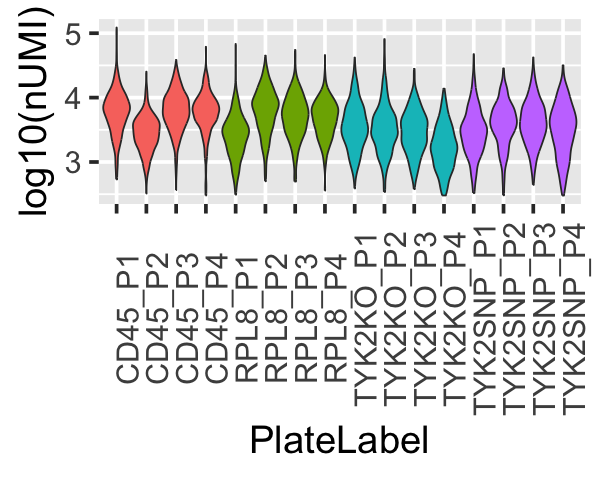

In [29]:
fig.size(4, 5)
ggplot(meta_ADT_filt)+
    geom_violin(aes(x = PlateLabel, y = log10(nUMI), fill = Condition), scale = 'width')+
    theme_g()+
    theme(legend.position = 'none', axis.text.x = element_text(angle = 90))

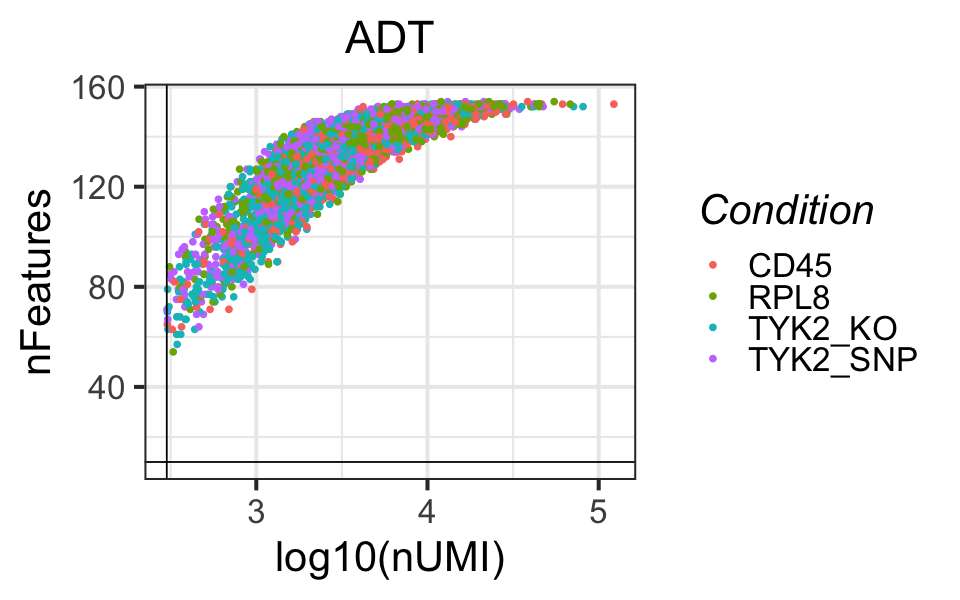

In [161]:
fig.size(5, 8)
ggplot(meta_ADT_filt %>% sample_n(nrow(meta_ADT_filt)))+
    geom_point(aes(x=log10(nUMI), y=nGenes, col = Condition))+
    theme_gy(25)+
    # geom_vline(xintercept = log10(1e3))+
    ggtitle('ADT')+
    ylab('nFeatures')+
    geom_vline(xintercept = log10(300))+
    geom_hline(yintercept = 10)

In [30]:
(meta_ADT_filt['nGenes'] <= 10) %>% table
(meta_ADT_filt['nUMI'] <= 300) %>% table
((meta_ADT_filt['nUMI'] <= 300) | (meta_ADT_filt['nGenes'] <= 10)) %>% table

.
FALSE 
 6038 

.
FALSE 
 6038 

.
FALSE 
 6038 

# Pre-process expression data

In [31]:
#Add rownames
rownames(meta_ADT_filt) <- meta_ADT_filt$cell
rownames(filt_meta) <- filt_meta$cell

Warning message:
“Setting row names on a tibble is deprecated.”
Warning message:
“Setting row names on a tibble is deprecated.”


In [32]:
#select only CD45 data for RNA
filt_meta_CD45 <- filter(filt_meta, Condition == "CD45")
filt_exprs_CD45 <- filt_exprs[,filt_meta_CD45$cell]

In [33]:
#select only CD45 data for ADT
meta_ADT_filt_CD45 <- filter(meta_ADT_filt, Condition == "CD45")
counts_ADT_filt_CD45 <- counts_ADT_filt[,meta_ADT_filt_CD45$cell]

In [35]:
### Pre-process based on metadata conditions
scale_exprs_CD45 = process_rna(filt_exprs_CD45, 
                               filt_meta_CD45)

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



In [36]:
scale_exprs_CD45 %>% dim

[1] 3000  901

In [37]:
scale_adt_CD45 = process_adt(counts_ADT_filt_CD45, 
                        meta_ADT_filt_CD45)

# Merging of Flow & DNA & RNAmeta & ADTmeta data

In [39]:
CD45Plots <- 
FLOW_DNA_CD45 %>% select(- Reference.y, 
                         -sgRNA_Sequence, 
                        -ExpectedChange) %>% 
inner_join(select(
    meta_ADT_filt_CD45, 
    cell, nUMI, nGenes)) %>% 
inner_join(select(
    filt_meta_CD45, 
    cell, nUMI, nGenes), by = "cell") %>%
rename(Reference = Reference.x) %>% 
add_count(genotype, name = "genotype_count") %>% 
filter(Plate != "P1") # Plate 1 had bad DNA data, clearly problematic. 
#Needs to be removed from all assays in this experiment

ERROR: Error in eval(expr, envir, enclos): object 'FLOW_DNA_CD45' not found


In [40]:
CD45Plots %>% dim

[1] 628  32

In [396]:
#export this table
write_csv(CD45Plots, "CD45Plots.csv")

In [7]:
CD45Plots <- read_csv("CD45Plots.csv")

Rows: 628 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (15): DNA_Barcode, Well_ID, Alleles, Reference, PlateLabel, Condition, R...
dbl (17): genotype, PB_CD81, BV605_CD45, BV750_CD45, SSC, FSC, FITC_CD45, PE...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# UMAPs

In [ ]:
### Run PCA/Harmony/UMAP based on metadata conditions

## RNA

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



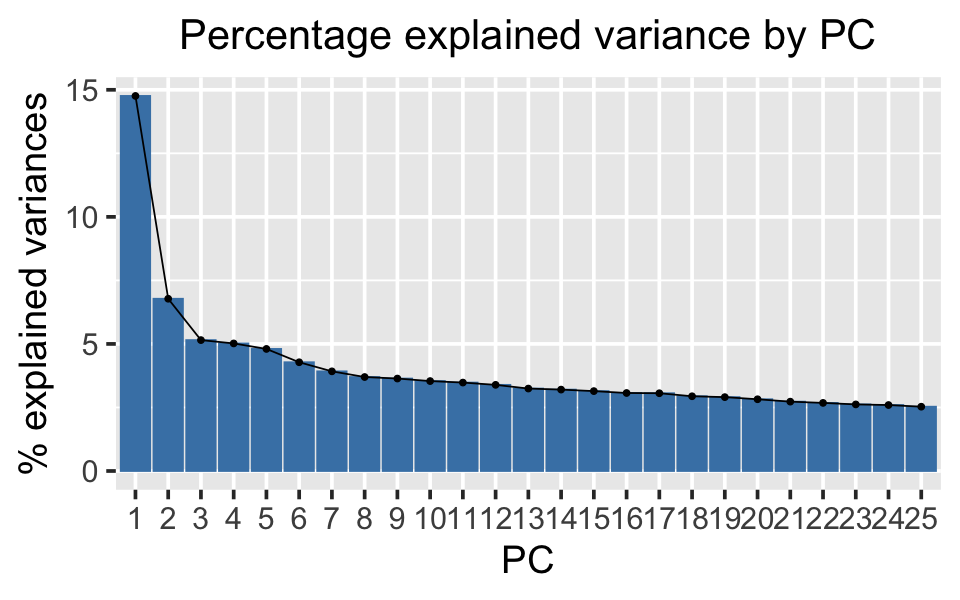

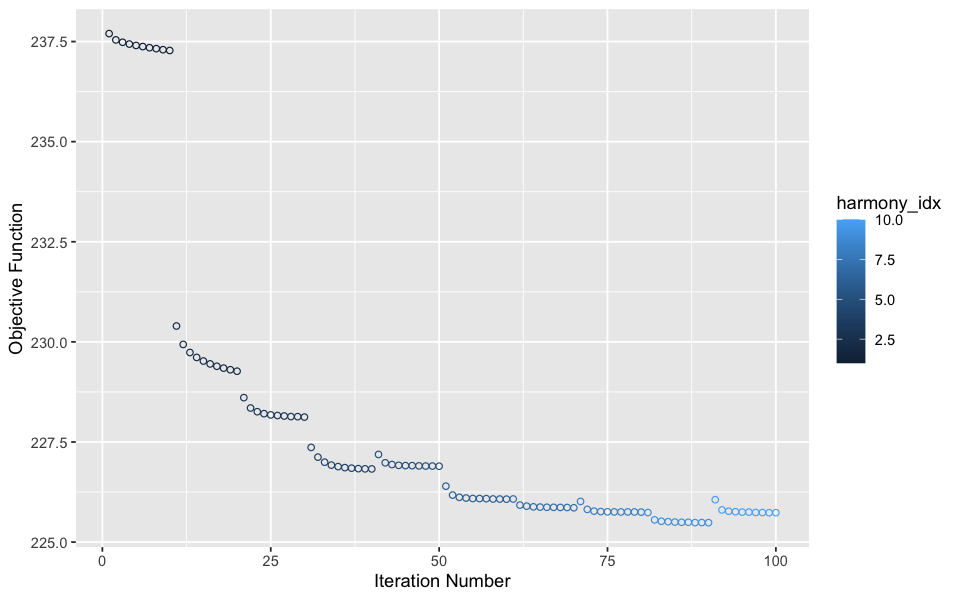

In [38]:
# Figure out overlapping cells with ADT, RNA, and DNA. Use that subset to cluster. 
filt_meta_CD45 <- filter(filt_meta, cell %in% CD45Plots$cell)
meta_umap_CD45 = pca_umap(scale_exprs_CD45[, filt_meta_CD45$cell], filt_meta_CD45, 
                          harmony_var = c('PlateLabel'))

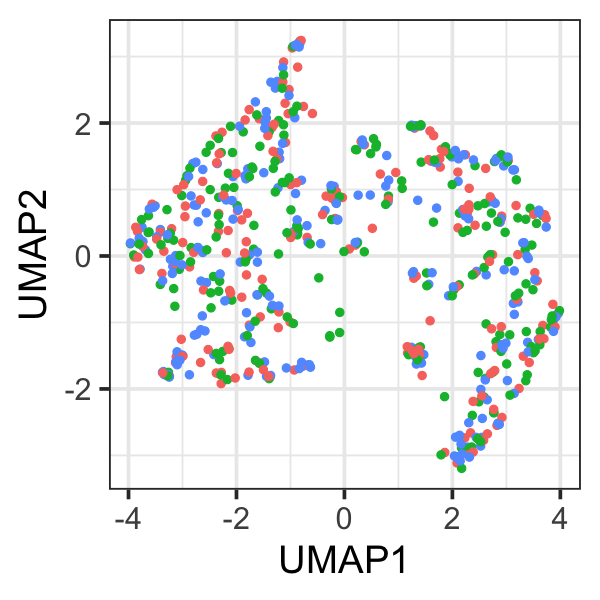

In [176]:
fig.size(5, 5)
ggplot(meta_umap_CD45 %>% sample_n(nrow(meta_umap_CD45)))+
    geom_point(aes(x = UMAP1, y = UMAP2, col = PlateLabel), size = 2)+
    theme_gy()+
theme(legend.position = "none")

In [177]:
scale_exprs <- normalizeData(filt_exprs, method = "log")

Joining with `by = join_by(cell)`


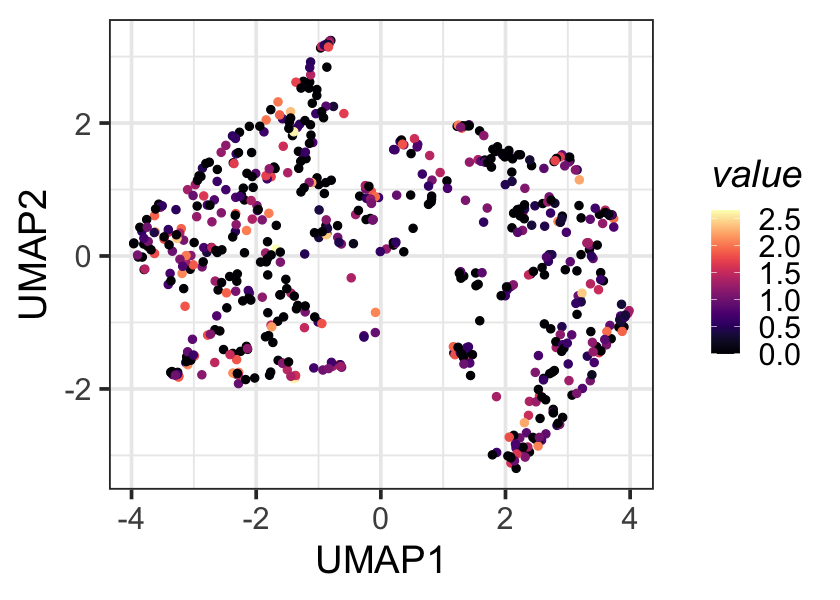

In [178]:
fig.size(5,7)
scale_exprs["PTPRC",meta_umap_CD45$cell] %>% as_tibble(rownames = "cell")  %>% 
inner_join(meta_umap_CD45) %>% 

    ggplot()+
    geom_point(aes(x = UMAP1, y = UMAP2, col = value), size = 2)+
    theme_gy()+
     scale_color_viridis(option = "magma")+ 
theme(legend.position = "right")


## ADT

In [190]:
meta_adt_filt_CD45 <- filter(meta_ADT_filt, cell %in% CD45Plots$cell)
meta_adt_filt_CD45 %>% dim

[1] 628  12

In [183]:
## filter adts to remove Igs ... causing problems. 
counts_ADT <- counts_ADT_filt[!grepl(rownames(counts_ADT_filt), pattern = "Ig"),]

In [198]:
scale_adt <- normalizeData(counts_ADT_filt_CD45[,meta_adt_filt_CD45$cell], method = "cellCLR") %>% 
scaleData

In [200]:
meta_ADT_filt_CD45 %>% dim
scale_adt %>% dim

[1] 1496   12

[1] 154 628

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony 8/10

Harmony 9/10

Harmony 10/10



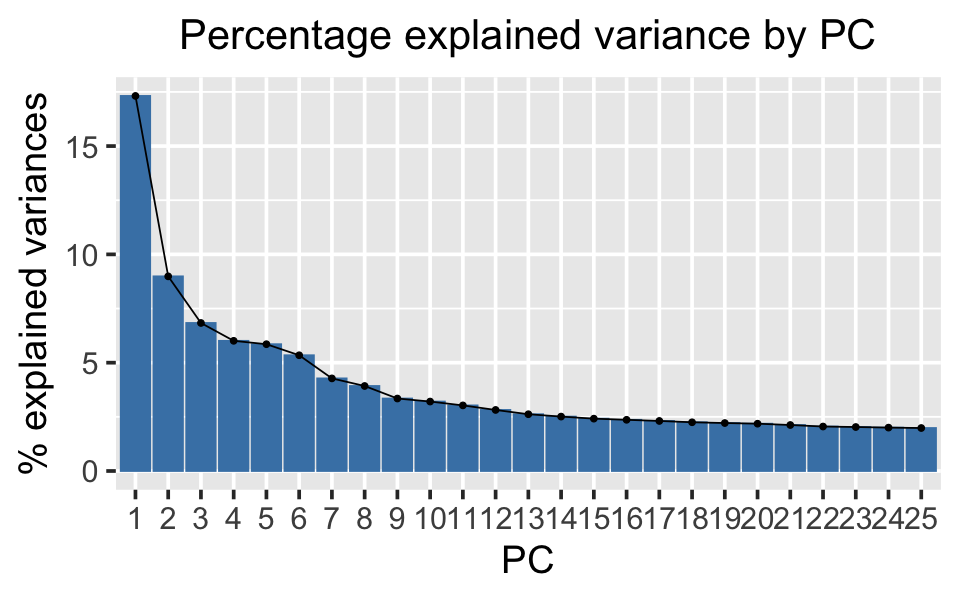

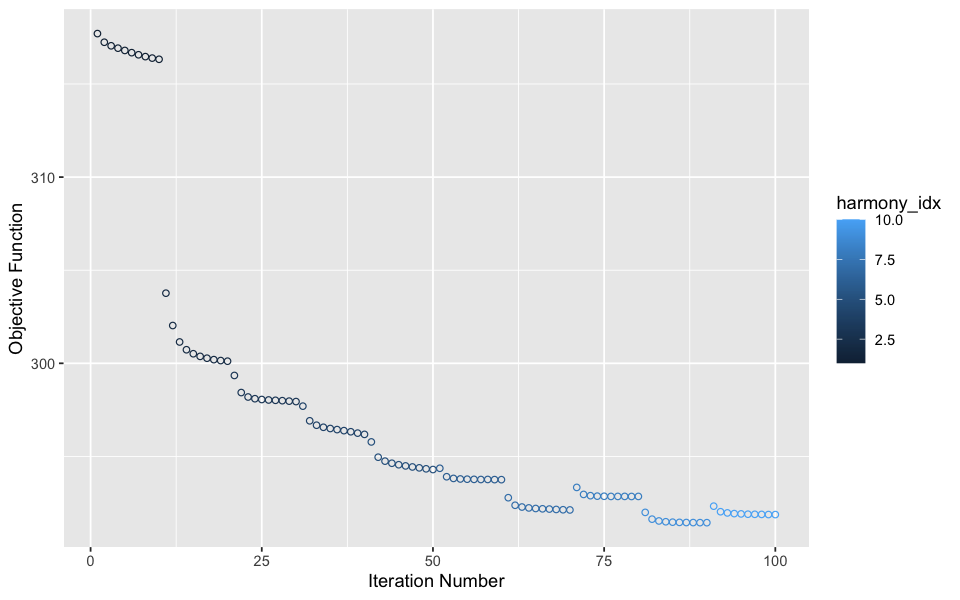

In [205]:
meta_umap_adt_CD45 <- pca_umap(scale_adt, meta_adt_filt_CD45, harmony_var = "PlateLabel")

Joining with `by = join_by(cell)`


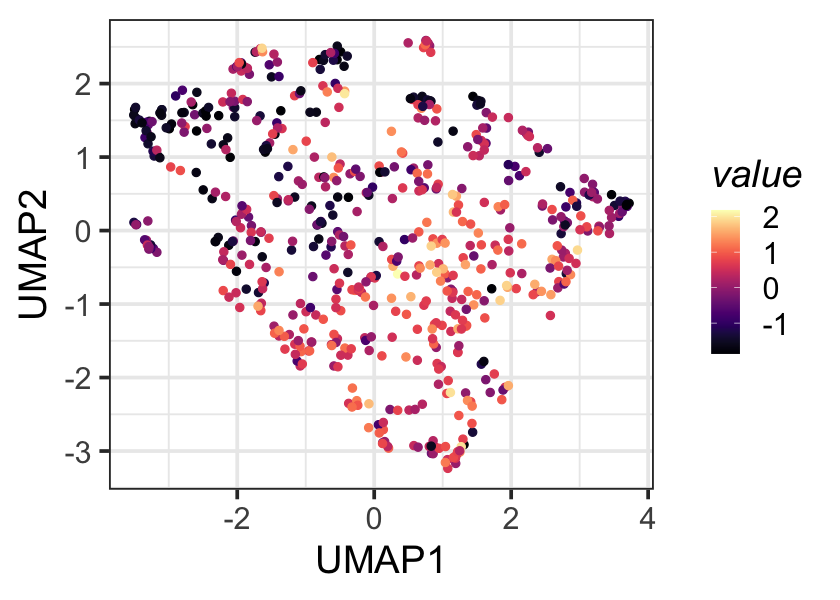

In [206]:
fig.size(5,7)
scale_adt["CD45",meta_umap_adt_CD45$cell] %>% as_tibble(rownames = "cell")  %>% 
inner_join(meta_umap_adt_CD45) %>% 

    ggplot()+
    geom_point(aes(x = UMAP1, y = UMAP2, col = value), size = 2)+
    theme_gy()+
     scale_color_viridis(option = "magma")+ 
theme(legend.position = "right")


Joining with `by = join_by(cell)`


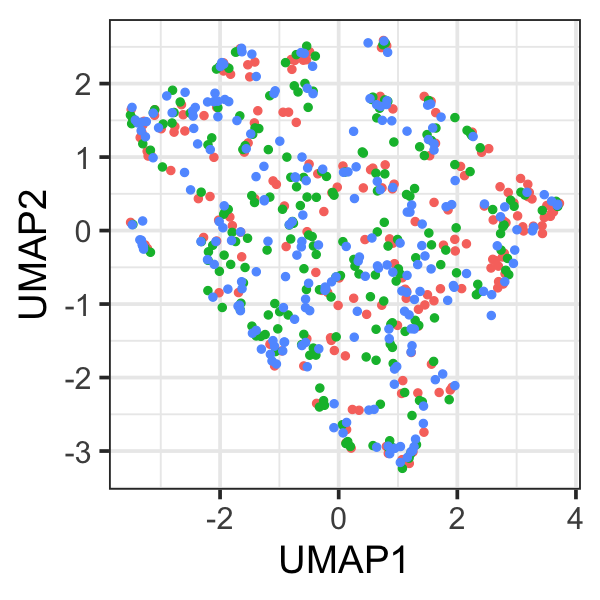

In [207]:
fig.size(5,5)
scale_adt["CD45",meta_umap_adt_CD45$cell] %>% as_tibble(rownames = "cell")  %>% 
inner_join(meta_umap_adt_CD45) %>% 

    ggplot()+
    geom_point(aes(x = UMAP1, y = UMAP2, col = PlateLabel), size = 2)+
    theme_gy()+
     #scale_color_viridis()+ 
theme(legend.position = "none")


# Clustering + DGE

## RNA

In [208]:
meta_umap_CD45.clust = do_cluster(meta_umap_CD45, resolution_list = seq(0.05, 0.5, 0.05))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 628
Number of edges: 20991

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9500
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 628
Number of edges: 20991

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 628
Number of edges: 20991

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8598
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 628
Number of edges: 20991

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8345
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version

In [218]:
table(meta_umap_CD45.clust$`res.0.2`)


  0   1 
356 272 

In [210]:
meta_umap_CD45.clust$cluster = meta_umap_CD45.clust$`res.0.2`

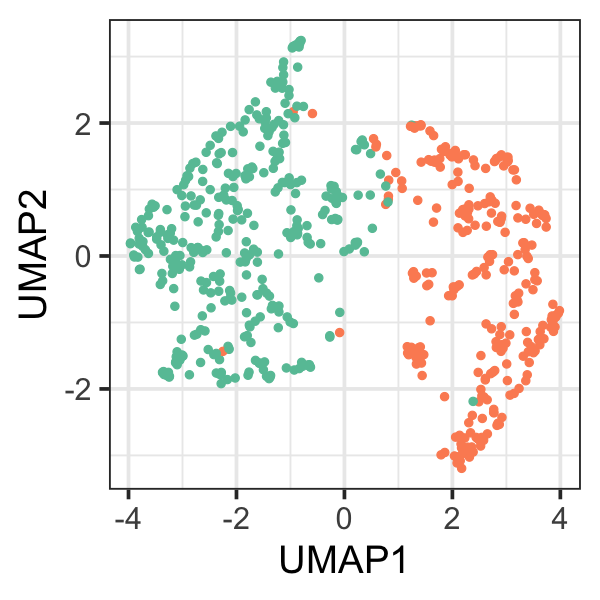

In [211]:
fig.size(5, 5)
ggplot(meta_umap_CD45.clust[sample(rownames(meta_umap_CD45.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
theme_gy() + 
theme(legend.position = "none") + 
scale_color_brewer(palette = "Set2")

In [214]:
fig.size(5, 5)
meta_umap_adt_CD45.clust %>% inner_join(select(CD45Plots3, cell, genotype3)) %>%


ggplot()+
    geom_point(aes(x= UMAP1, y = UMAP2, col = factor(genotype3, levels = c("Control",
                                                                         "C/C", 
                                                                         "C/T", 
                                                                         "T/T"))), size = 2)+
  theme_gy() + 
theme(legend.position = "right")+
labs(color = "Genotype") +
facet_wrap(~factor(genotype3, levels = c("Control","C/C", "C/T", "T/T")))  + 
theme(axis.text.x=element_blank(), #remove x axis labels
        axis.ticks.x=element_blank(), #remove x axis ticks
        axis.text.y=element_blank(),  #remove y axis labels
        axis.ticks.y=element_blank()  #remove y axis ticks
        ) + 
theme(legend.key = element_blank(), strip.background = element_rect(colour="black", fill="white") ) +
xlab("") + 
ylab("") + 
theme(legend.position = "none")


ERROR: Error in eval(expr, envir, enclos): object 'meta_umap_adt_CD45.clust' not found


In [219]:
df<-meta_umap_CD45.clust %>% arrange(cluster)
dge_CD45 = wilcoxauc(scale_exprs_CD45[,df$cell], df$cluster)
var_genes_CD45 = top_markers(dge_CD45, 10) %>% head(10) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(scale_exprs_CD45[var_genes_CD45,df$cell ]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = df$cluster)
rownames(mat_col) <- rownames(df)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(scale_exprs_CD45[var_genes_CD45, df$cell])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(scale_exprs_CD45[var_genes_CD45,df$cell ])))

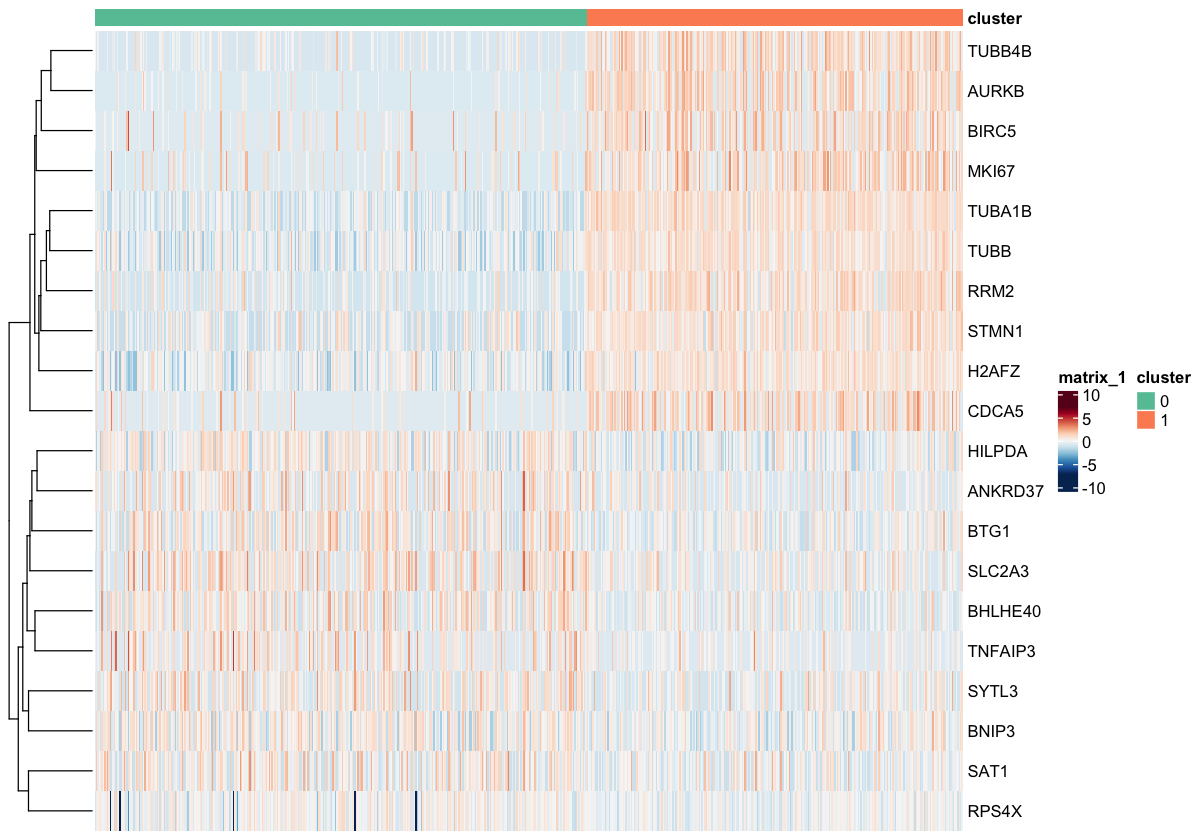

In [221]:
fig.size(7, 10)
pheatmap(scale_exprs_CD45[c(var_genes_CD45), df$cell],
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, 
         fontsize = 10,
         cluster_cols = F,
         annotation_colors = list(cluster = c(
                                  `0` = "#66C2A5", 
                                  `1` = "#FC8D62" 
            #                      `2` = "#8DA0CB"
                                     )),
        cluster_rows = mat_cluster_rows,

        )

## ADT

In [222]:
meta_umap_adt_CD45.clust = do_cluster(meta_umap_adt_CD45, resolution_list = seq(0.1, 1, 0.1))

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 628
Number of edges: 22507

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 628
Number of edges: 22507

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 628
Number of edges: 22507

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7124
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 628
Number of edges: 22507

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.6652
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version

In [225]:
table(meta_umap_adt_CD45.clust$'res.0.3')


  0   1 
497 131 

In [226]:
meta_umap_adt_CD45.clust$cluster = meta_umap_adt_CD45.clust$`res.0.3`

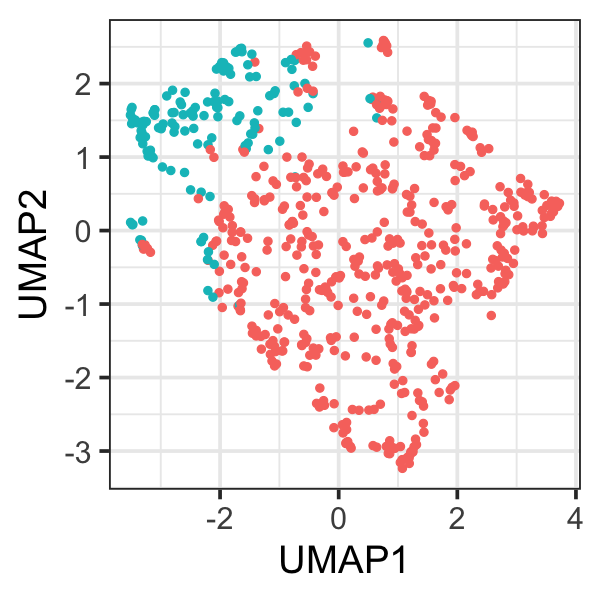

In [227]:
fig.size(5, 5)
ggplot(meta_umap_adt_CD45.clust[sample(rownames(meta_umap_adt_CD45.clust)), ])+
    geom_point(aes(x= UMAP1, y = UMAP2, col = cluster), size = 2)+
  theme_gy() + 
theme(legend.position = "none")

In [228]:
fig.size(5, 7)
meta_umap_adt_CD45.clust %>% inner_join(select(CD45Plots3, cell, genotype3)) %>%


ggplot()+
    geom_point(aes(x= UMAP1, y = UMAP2, col = factor(genotype3, levels = c("Control",
                                                                         "C/C", 
                                                                         "C/T", 
                                                                         "T/T"))), size = 2)+
  theme_gy() + 
theme(legend.position = "right")+
labs(color = "Genotype") +
facet_wrap(~factor(genotype3, levels = c("Control","C/C", "C/T", "T/T")))

ERROR: Error: object 'CD45Plots3' not found


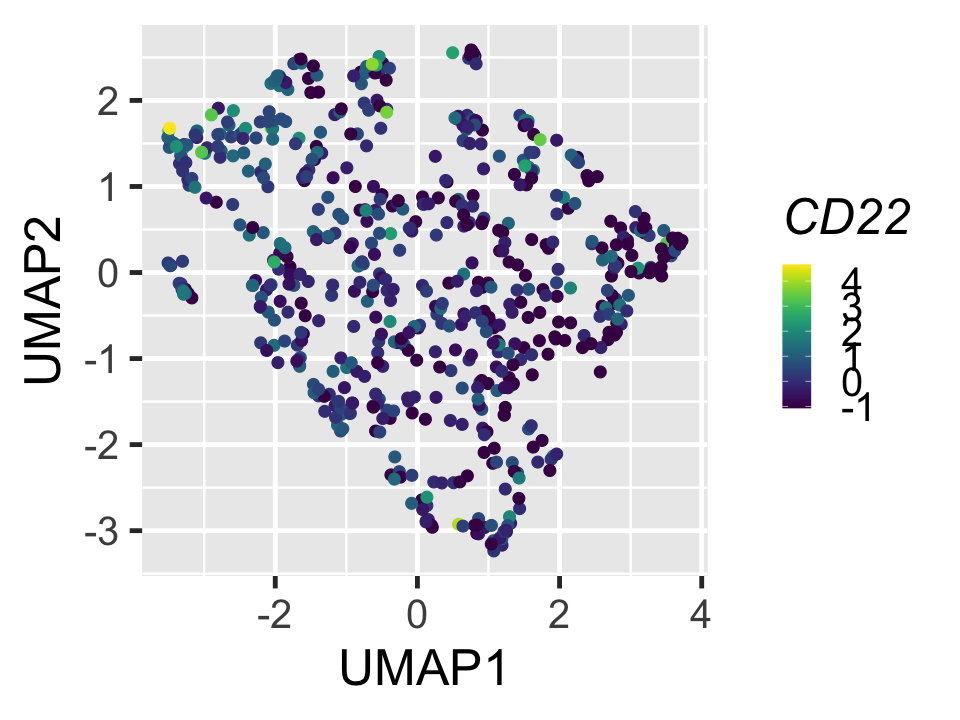

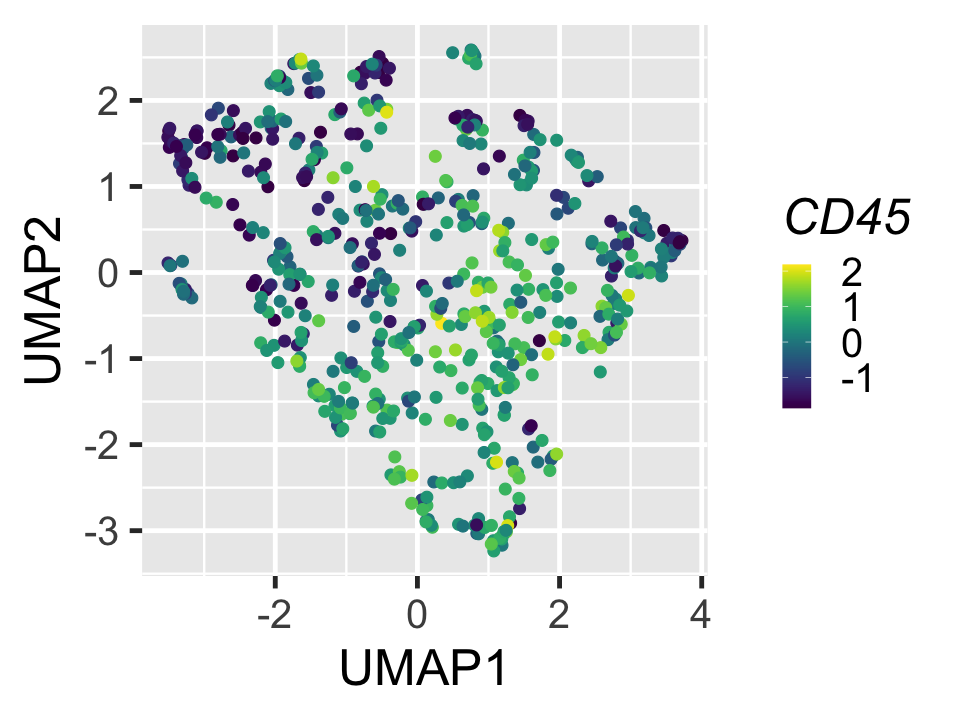

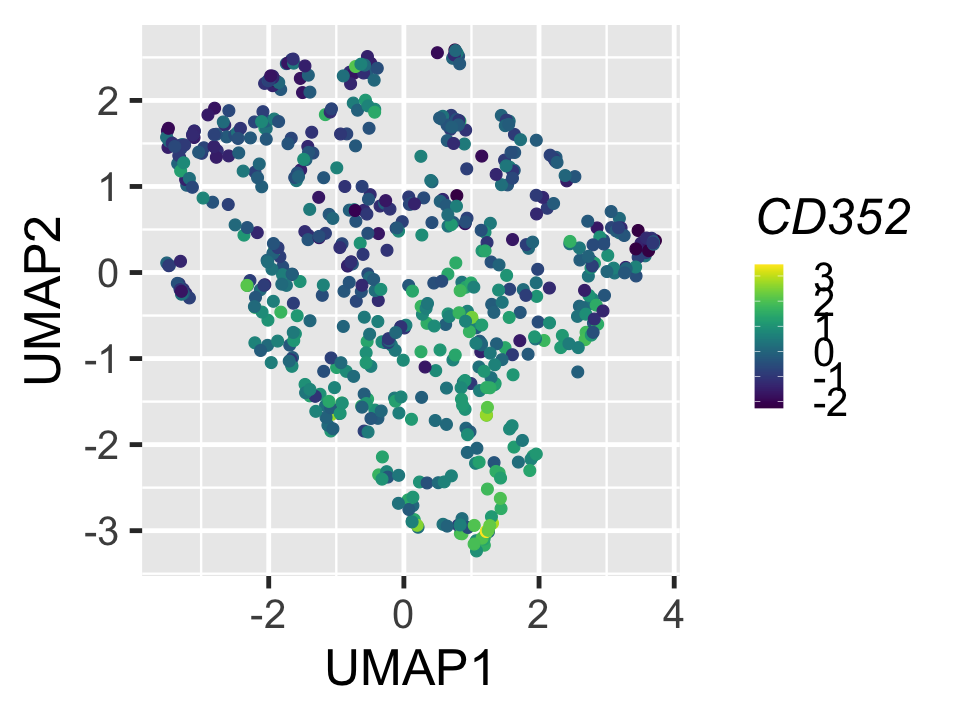

In [234]:
plot_exprs(scale_adt, meta_umap_adt_CD45, c("CD22", "CD45", "CD352"))

In [235]:
df<-meta_umap_adt_CD45.clust %>% arrange(cluster)
matrix <- scale_adt[,df$cell]

dge_CD45 = wilcoxauc(matrix, df$cluster)
var_genes_CD45 = top_markers(dge_CD45, 10) %>% head(10) %>% select(-rank) %>% 
                        unlist %>% unique 
cmax = abs(matrix[var_genes_CD45,]) %>% unlist %>% max #%>% quantile(.995)

# Data frame with column annotations.
mat_col <- data.frame(cluster = df$cluster)
rownames(mat_col) <- rownames(df)


# Sort dendogram
mat_cluster_cols <- hclust(dist(t(matrix[var_genes_CD45, ])))
mat_cluster_cols <- sort_hclust(mat_cluster_cols)
mat_cluster_rows <- sort_hclust(hclust(dist(matrix[var_genes_CD45, ])))

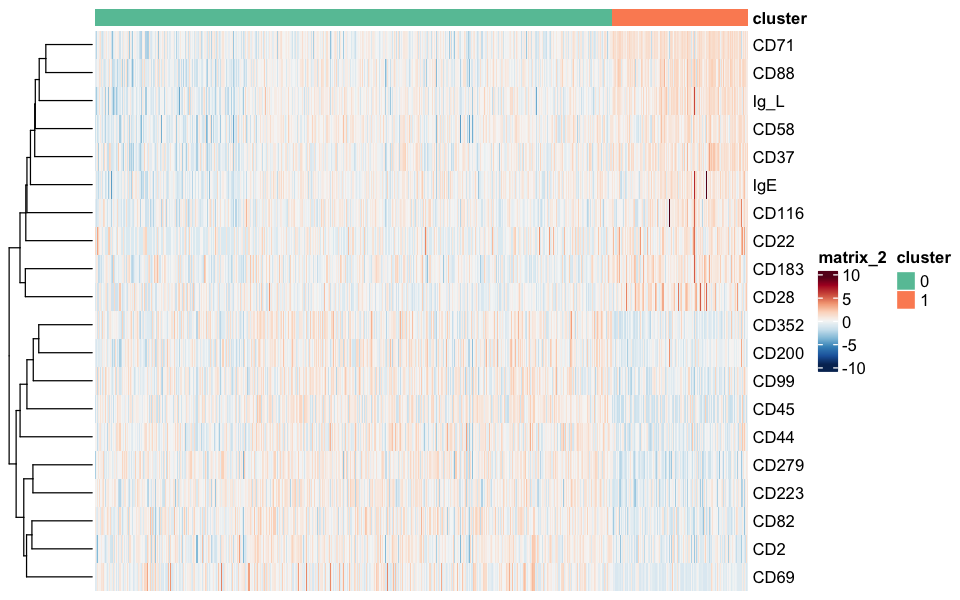

In [236]:
fig.size(5, 8)
pheatmap(as.matrix(matrix[c(var_genes_CD45), df$cell]),
         breaks = seq(-cmax, cmax, length.out = 100),
        color = colorRampPalette(brewer.pal(11, "RdBu"))(100) %>% rev,
        show_colnames = FALSE,
         annotation_col = mat_col, 
         fontsize = 10,
         cluster_cols = F,
         annotation_colors = list(cluster = c(
                                  `0` = "#66C2A5", 
                                  `1` = "#FC8D62" 
                                  #`2` = "#8DA0CB"
                                     )),
        cluster_rows = mat_cluster_rows,

        )

In [237]:
intersect(rownames(meta_umap_CD45),
         rownames(meta_umap_adt_CD45)) %>% length

[1] 628

In [238]:
# Compare cluster concordance in RNA vs protein
intersect_cells = intersect(rownames(meta_umap_adt_CD45.clust), rownames(meta_umap_CD45.clust))
concordance_RNAprot_DQB1 = table(meta_umap_adt_CD45.clust[intersect_cells, 'cluster'],
                                 meta_umap_CD45.clust[intersect_cells, 'cluster']) %>% as.data.frame

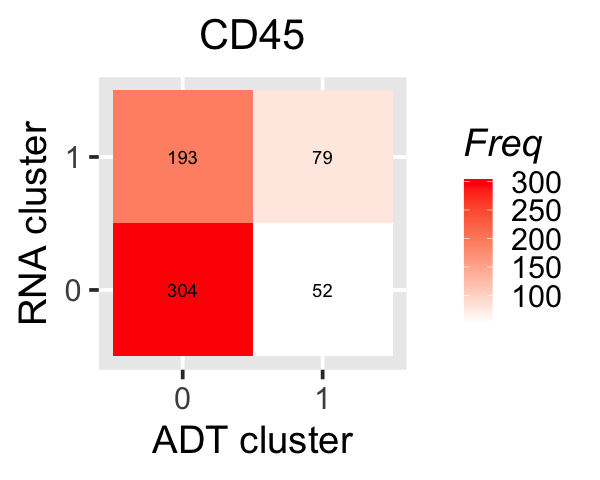

In [239]:
# Compare cluster concordance in RNA vs protein
fig.size(4, 5)
ggplot(concordance_RNAprot_DQB1)+
    geom_tile(aes(x = Var1, y = Var2, fill = Freq))+
    geom_text(aes(x = Var1, y = Var2, label = Freq)) +
    scale_fill_gradient(low = "white", high = "red")+
    theme_g()+
    xlab('ADT cluster')+
    ylab('RNA cluster')+
    ggtitle('CD45')

In [ ]:
## RNA PCS should be controlled in the model. RNA is being split based on proliferation status.

## It's funny that ADT doesn't capture that. How curious. 

In [241]:
## Can we quickly take a look at CD45 and PTPRC divided by genotype
fig.size(5,8)

inner_join(
    scale_adt["CD45", CD45Plots$cell] %>% as_tibble(rownames = "cell"), 
    norm_exprs["PTPRC", CD45Plots$cell] %>% as_tibble(rownames = "cell"), by = "cell"
    ) %>% inner_join(CD45Plots3) %>% 

ggplot(aes(value.x, value.y, color= as.factor(Dosage))) + 
geom_point()+
theme_gy() + stat_cor()


ERROR: Error: object 'CD45Plots3' not found


# Figures

In [7]:
CD45Plots <- read_csv("CD45Plots.csv")

Rows: 628 Columns: 32
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (15): DNA_Barcode, Well_ID, Alleles, Reference, PlateLabel, Condition, R...
dbl (17): genotype, PB_CD81, BV605_CD45, BV750_CD45, SSC, FSC, FITC_CD45, PE...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Bulk PTPRC editing, import analyzed flow data

In [1774]:
read_csv("BulkCD45.csv")

Rows: 24 Columns: 6
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample, Experiment, Status
dbl (3): PercentParent, CD4MFI, CD25MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sample  Experiment Status PercentParent CD4MFI CD25MFI
1  C0002YB CRISPR     Het    31.90         4361   2168   
2  C0002YB Control    Het     3.41         3975   1209   
3  C0004YB CRISPR     Het    37.70         4066   2755   
4  C0004YB Control    Het     7.84         3386   1188   
5  C0006YB CRISPR     Het    28.10         4254   1561   
6  C0006YB Control    Het    29.90         3808   1579   
7  C0010YB CRISPR     Het    26.10         4352   1300   
8  C0010YB Control    Het     2.54         3942   1232   
9  C0002YB CRISPR     WT     21.00         3641   2198   
10 C0002YB Control    WT     89.20         3678   1748   
11 C0004YB CRISPR     WT     35.60         3413   2676   
12 C0004YB Control    WT     76.20         3016   1884   
13 C0006YB CRISPR     WT     21.90         3568   2123   
14 C0006YB Control    WT     51.10         4032   2283   
15 C0010YB CRISPR     WT     19.20         3663   1835   
16 C0010YB Control    WT     89.50         3619   1902   
17 C0002YB CRISPR     KO     40.00         6146   2529   
18 C0002YB Control    KO      0.00            0      0   
19 C0004YB CRISPR     KO     19.90         5762   3312   
20 C0004YB Control    KO      0.00            0      0   
21 C0006YB CRISPR     KO     39.30         5604   1407   
22 C0006YB Control    KO      0.00            0      0   
23 C0010YB CRISPR     KO     46.20         5874   1462   
24 C0010YB Control    KO      0.01         3926   1464

Rows: 32 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample, Experiment, Status
dbl (3): PercentParent, CD4MFI, CD25MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Removed 4 rows containing missing values (`stat_boxplot()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Rows: 32 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample, Experiment, Status
dbl (3): PercentParent, CD4MFI, CD25MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE

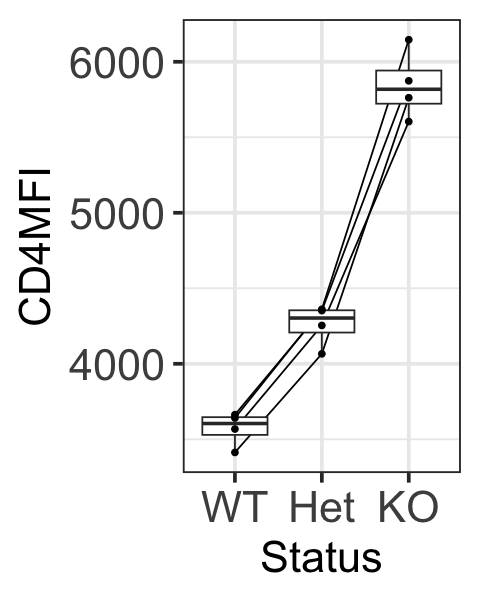

Rows: 32 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample, Experiment, Status
dbl (3): PercentParent, CD4MFI, CD25MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


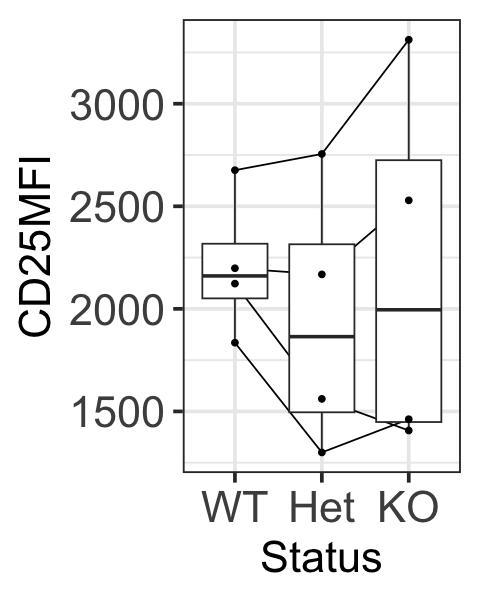

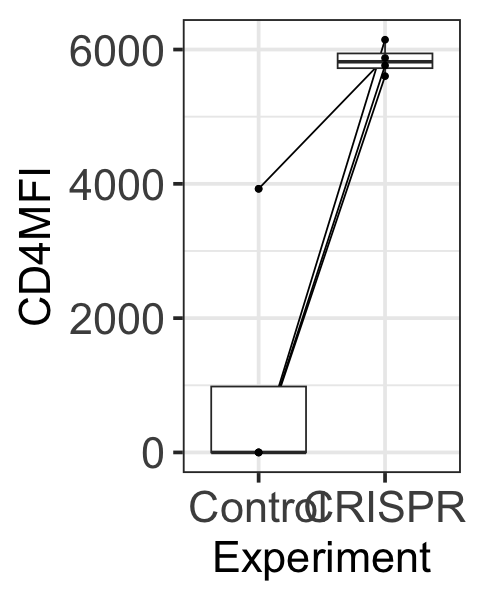

In [81]:
fig.size(5,4)
read_csv("BulkCD45.csv") %>% filter(Experiment == "CRISPR") %>%
ggplot(aes(Status, CD4MFI))  + 
geom_line(aes(group = Sample)) + geom_boxplot() + 
scale_x_discrete(limits = c("WT", "Het", "KO"))+ geom_point() + 
theme_gy() 

fig.size(5,4)
read_csv("BulkCD45.csv") %>% filter(Experiment == "CRISPR") %>%
ggplot(aes(Status, CD25MFI))  + 
geom_line(aes(group = Sample)) + geom_boxplot() + 
scale_x_discrete(limits = c("WT", "Het", "KO"))+ geom_point() + 
theme_gy() 

fig.size(5,4)
read_csv("BulkCD45.csv") %>% filter(Status == "KO") %>%
ggplot(aes(Experiment, CD4MFI))  + 
geom_line(aes(group = Sample)) + geom_boxplot() + geom_point() + 
theme_gy() 



In [ ]:
fig.size(5,4)
read_csv("BulkCD45.csv") %>% filter(Experiment == "CRISPR") %>%
ggplot(aes(Status, CD25MFI))  + 
geom_line(aes(group = Sample)) + geom_boxplot() + 
scale_x_discrete(limits = c("WT", "Het", "KO"))+ geom_point() + 
theme_gy() 

In [73]:
BulkCD45 <- read_csv("BulkCD45.csv")

Rows: 32 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Sample, Experiment, Status
dbl (3): PercentParent, CD4MFI, CD25MFI

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [75]:
compare_means(CD25MFI~Experiment, BulkCD45)

.y.     group1 group2  p          p.adj p.format p.signif method  
1 CD25MFI CRISPR Control 0.01666011 0.017 0.017    *        Wilcoxon

In [77]:
BulkCD45 %>% group_by(Experiment) %>% summarize(mean(CD25MFI))

Experiment mean(CD25MFI)
1 CRISPR     2106.500     
2 Control    1359.875

## DNA

In [32]:
#Defineplotting Order
order <- CD45Plots$genotype %>% table %>% as_data_frame %>% arrange(`n`)
order <- as.character(order$`.`)

Warning message:
“`as_data_frame()` was deprecated in tibble 2.0.0.
ℹ Please use `as_tibble()` (with slightly different semantics) to convert to a
  tibble, or `as.data.frame()` to convert to a data frame.”


In [33]:
CD45Plots %>% dim

[1] 628  32

In [34]:
CD45Plots$Plate %>% table

.
 P2  P3  P4 
187 214 227 

Saving 7 x 7 in image


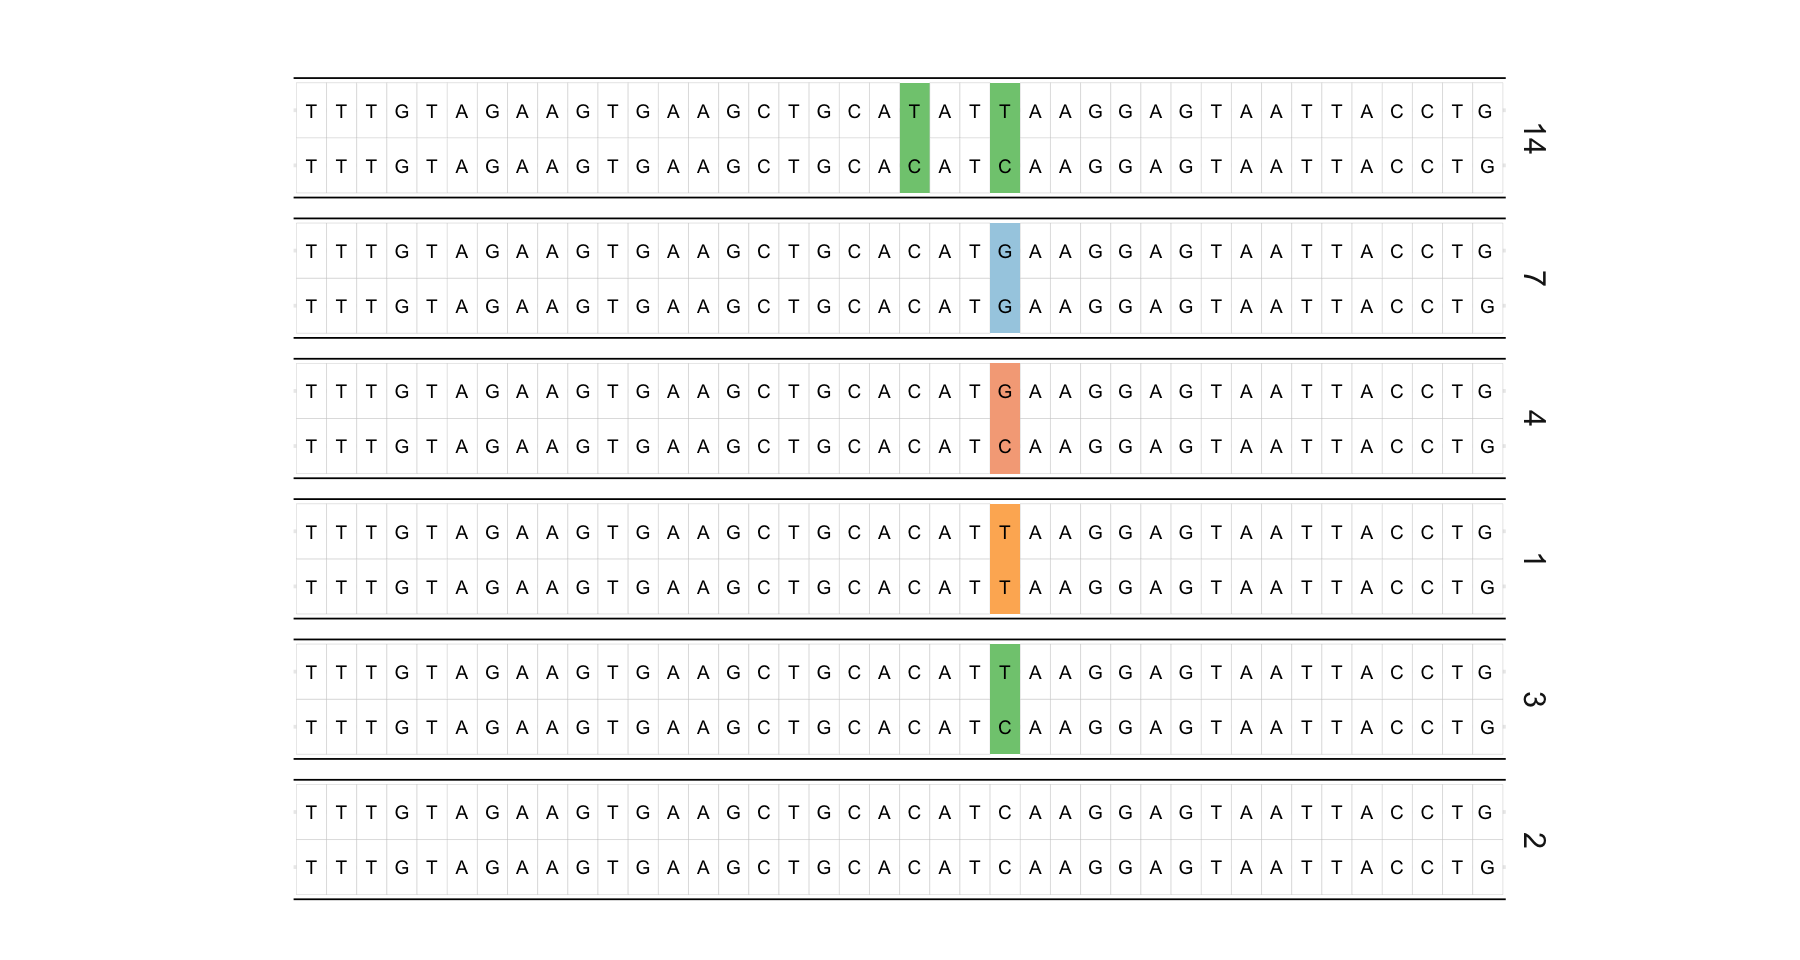

In [37]:
fig.size(8,15)
df<- GenotypeHeatmap2(CD45Plots, 2)
df$Genotype <- factor(df$Genotype, levels = c(paste0("G", 100:1)))

g <-     

g<- df %>% #the number is the filter on genotype 
ggplot(aes(x = reorder(position, as.integer(position)), 
           y = allele, fill = `value`)) + 
    geom_tile(aes(color = value), width=1, height=1) +
        geom_text(data = dplyr::filter(df),
                  aes(label = `allele_value`), angle = 0, size = (4)) + 
        scale_fill_manual(values = 
                    c(R = 'white',
                    CC = "#5194ed", 
                      TT = "#fdb462", 
                      CT = "#7fc97f", 
                      GT = "#ef3b2c",
                      CG = "#f5aa87",
                      GG = "#a6cee3",  
                      AG = "#f5bbba",
                      AA = "#fae1e1",
                     `-A`= "grey90", 
                     `-T` = "grey90", 
                     `-C` = "grey90", 
                     `-G` = "grey90", 
                     `--` ="grey80"))+ 
        scale_color_manual(values = 
                   c(R = 'grey',
                      CC = "NA", 
                      TT = "NA", 
                      CT = "NA", 
                      GT = "NA",
                      CG = "NA",
                      GG = "NA",  
                     AG = "NA"))+ 
     #c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33"))
        ggtitle("") + 
        theme_gy()+
    xlab("")+
    theme(aspect.ratio = 0.1)+ 
    ylab("") +
    theme(axis.text.y = element_text(size = 0, angle = 0, hjust = .5, vjust = .5),
          axis.text.x = element_text(size = 0),
        axis.title.x = element_text(size = 20, angle = 0, hjust = .5, vjust = .5),
        axis.title.y = element_text(size = 20, angle = 90, hjust = .5, vjust = .5),
          axis.ticks.y = element_blank(),
         legend.position = "none") + 
    scale_x_discrete(breaks=NULL) + 
    facet_grid(factor((genotypes), levels = c(14:4,1,3,2))~.)+ 
theme(
  strip.background = element_blank(),
  strip.text.x = element_blank(), 
    panel.border=element_blank()

) + 
    annotate(geom = 'segment', y = Inf, yend = Inf, color = 'black', x = -Inf, xend = Inf, linewidth = 1) + 

    annotate(geom = 'segment', y = -Inf, yend = -Inf, color = 'black', x = -Inf, xend = Inf, linewidth = 1)
plot(g)

## save the plot
suppressWarnings({ 
    ggsave(g, filename = "CD45Genotypes.png", device = "png", dpi = 300)
    })

`summarise()` has grouped output by 'as.factor(Edited_Index)',
'as.factor(Individual_Index)'. You can override using the `.groups` argument.
Joining with `by = join_by(genotype, Individual_Index, Edited_Index)`


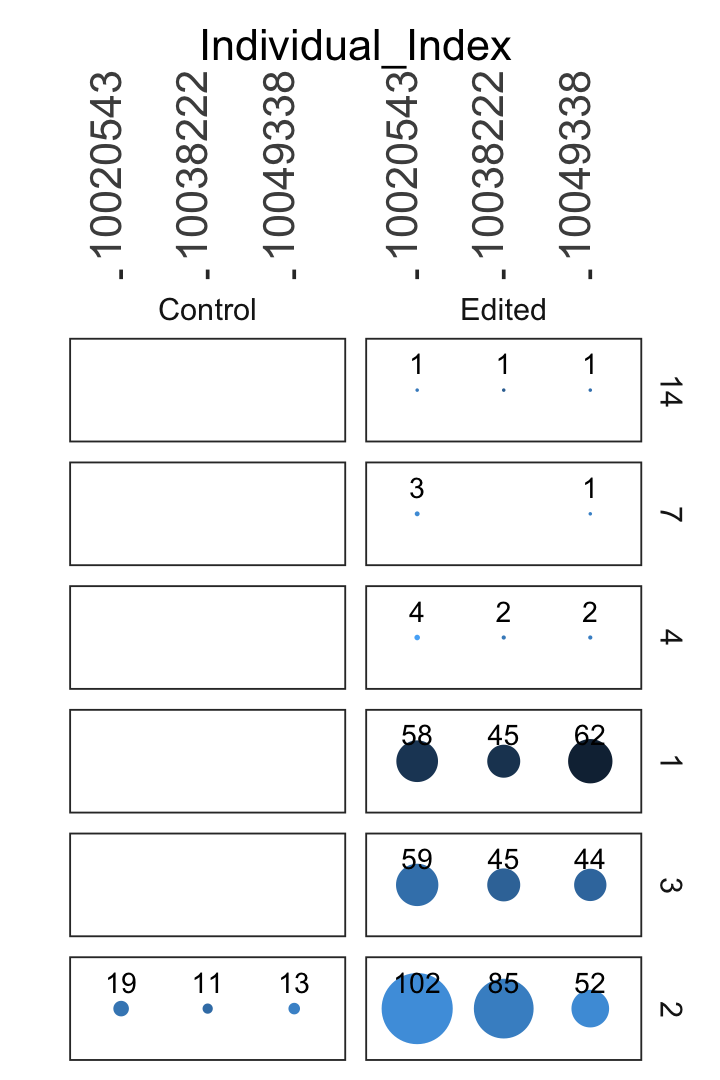

In [45]:
test2 <- filter(CD45Plots, genotype_count >2) # Filter for > 2 cells per genotype

fig.size(9,6)
g <- 

table(test2$genotype, test2$Individual_Index, test2$Edited_Index) %>% 
as.data.frame() %>% rename(Individual_Index = Var2, Edited_Index = Var3, genotype = Var1) %>% 
inner_join( 
test2 %>% group_by(as.factor(Edited_Index), as.factor(Individual_Index), as.factor(genotype)) %>% 
    summarise(mean(FITC_CD45)) %>% rename(Individual_Index = `as.factor(Individual_Index)`, 
                                          Edited_Index = `as.factor(Edited_Index)`, genotype = `as.factor(genotype)`)
)%>% na.omit%>% {
    
    ggplot(., aes(Individual_Index, 
                  fill = log10(`mean(FITC_CD45)`), size = Freq)) +
      geom_point(aes(y = 0),shape = 21, stroke = 0) +
      #geom_hline(yintercept = seq(.5, 4.5, 1), size = .2) +
  scale_x_discrete(position = "top") +
  scale_radius(range = c(1,20)) +
    geom_text(aes(y = 0, label = Freq), size =6, vjust = -0.8)+
  theme_gy() +
  theme(legend.position = "none", 
        panel.grid.major = element_blank(),
        legend.text = element_text(size = 8),
        legend.title = element_text(size = 8), 
       axis.text.x = element_text(angle = 90)) + 
    ylab("") + 
    scale_y_discrete(expand = c(0.1,0.5)) + 
    facet_grid(factor((genotype), levels = c(14:4,1,3,2))~Edited_Index) + 
    theme(
  strip.background = element_blank(),
  #strip.text.x = element_blank(), 
    #panel.border=element_blank(), 
   # strip.text.y = element_blank()  
        )
} 
plot(g)
suppressWarnings({ 
    ggsave(g, filename = "g.png", device = "png", dpi = 300, width = 6, height = 9)
  })

In [40]:
norm_exprs <- singlecellmethods::normalizeData(filt_exprs, method = "log")

'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").



Joining with `by = join_by(cell)`


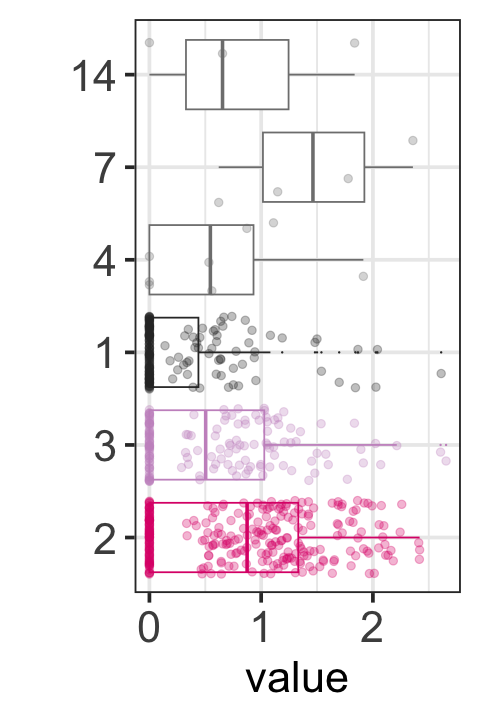

In [52]:
#Gene expression plot
g <- 

norm_exprs["PTPRC",] %>% as_tibble(rownames = "cell") %>% inner_join(CD45Plots) %>%  
    filter(genotype_count >2) %>% na.omit() %>%

ggplot(aes(x = factor(genotype, levels = rev(c(14:4,1,3,2))), 
           y = value, 
           color = factor(genotype, levels = (c(14:4,1,3,2))))) + 
    geom_boxplot(outlier.size = 0) +
     geom_jitter(alpha = 0.3, size = 2) +   
    theme_gy() + 
theme(legend.position = "none")+ 
xlab("") + 
scale_color_manual(values =c( 
                 "14" = "grey50",
                  "7" = "grey50",
                   "4" = "grey50",
                  "3" = "#C994C7",
                  "2" = "#DD1C77", 
                  "1" = "grey20"))+ 

coord_flip()
fig.size(6,4)
plot(g)
## save plot
suppressWarnings({ 
    ggsave(g, filename = "g2.png", device = "png", dpi = 300, width = 4, height = 6)
    })


Joining with `by = join_by(cell)`


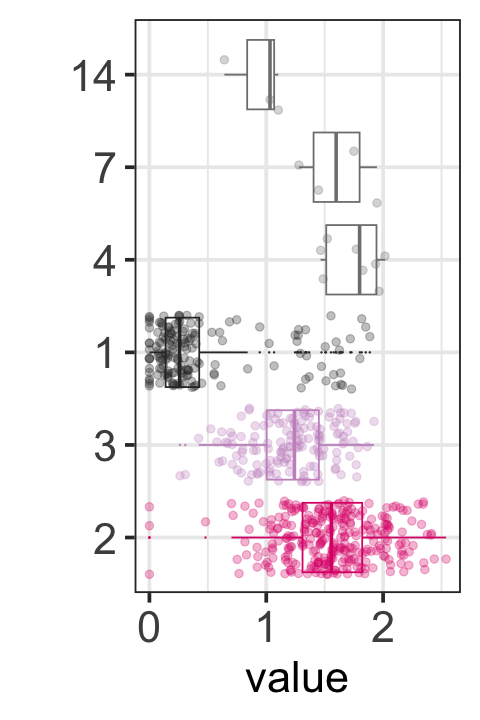

In [51]:
#protein expression plot
g <- 

norm_adt["CD45",] %>% as_tibble(rownames = "cell") %>% inner_join(CD45Plots) %>%  
    filter(genotype_count >2) %>% na.omit() %>%

ggplot(aes(x = factor(genotype, levels = rev(c(14:4,1,3,2))), 
           y = value, 
           color = factor(genotype, levels = (c(14:4,1,3,2))))) + 
    geom_boxplot(outlier.size = 0) +
     geom_jitter(alpha = 0.3, size = 2) +   
    theme_gy() + 
theme(legend.position = "none")+ 
xlab("") + 
scale_color_manual(values =c( 
                 "14" = "grey50",
                  "7" = "grey50",
                   "4" = "grey50",
                  "3" = "#C994C7",
                  "2" = "#DD1C77", 
                  "1" = "grey20"))+ 

coord_flip()
fig.size(6,4)
plot(g)
## save plot
suppressWarnings({ 
    ggsave(g, filename = "g3.png", device = "png", dpi = 300, width = 4, height = 6)
    })


# RNA linear modeling

In [ ]:
### Excluding plate 1, unreliable DNA data

In [9]:
## Do more comparisons of control vs Edited. 
CD45Plots2 <- filter(CD45Plots, genotype %in% c(1:3)) %>% mutate(Dosage = ifelse(
genotype == 2, 0, ifelse( genotype == 1, 2, 1))) %>% filter(Edited_Index == "Edited") %>% na.omit 

In [10]:
CD45Plots3 <- filter(CD45Plots, genotype %in% c(1:3)) %>% mutate(Dosage = ifelse(
genotype == 2, 0, ifelse( genotype == 1, 2, 1))) %>% na.omit

In [12]:
norm_exprs <- normalizeData(filt_exprs, method = "log")

ERROR: Error in eval(expr, envir, enclos): object 'filt_exprs' not found


In [13]:
library(MASS)
library(tidyverse)


Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


The following object is masked from ‘package:patchwork’:

    area





## Linear Modeling

In [65]:
# Linear model including a random effect for plate. (lmer)
#Subset Exprs (normalized for lmer)
## In this example, PCS are hurting me. 
df <- CD45Plots2
cells <- df$cell
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- exprs[, df$cell] #expression in this set of cells

nCells = rowSums(Exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.15) %>% rownames, cells] #Expressed in 30% of cells. 
genes <- rownames(Exprs)

Exprs %>% dim
genes %>% length

suppressMessages({
    suppressWarnings({
CD45_lm_Dosage <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Individual_Index + Dosage, 
               )
    
     return(c(coefficients(lm1), "pval" = anova(lm0,lm1, test = "Chisq")[2,8]))
        })
    })
    })

CD45_lm_Dosage<- 
    t(CD45_lm_Dosage) %>% 
    as_tibble(rownames = "gene") %>% 
    mutate(padjBH = p.adjust(pval, method = "BH"))

.
  0   1   2 
239 148 165 

[1] 5544  552

[1] 5544

In [66]:
CD45_lm_Dosage%>% write_csv("CD45_lm_Dosage.csv")

In [69]:
CD45_lm_Dosage %>% filter(padjBH < 0.05) %>% arrange(pval)

gene    (Intercept) log10(nUMI.y) PlateP3     PlateP4    
1 PTPRC    -8.554177  2.305599       0.30193346  0.16286289
2 ANXA3   -13.905199  2.672523       0.23053509  0.03674371
3 TNFRSF4  -4.655002  2.084593       0.03033283  0.14226673
4 CHCHD10 -10.795611  2.797628      -0.16662413  0.06944594
5 PSMA5   -10.348666  2.729204       0.14387717 -0.19195699
6 TRBC2    -5.858240  2.232350       0.18699033  0.09293436
7 DCTN3    -7.704257  1.917886      -0.18737895 -0.12663380
  Individual_Index10038222 Individual_Index10049338 Dosage     pval        
1 -0.1930865               -0.23906325              -0.6669936 1.110223e-16
2  0.8963664                0.22522846               0.8834488 1.544349e-08
3 -0.1613581                0.10488883              -0.2655130 2.734006e-06
4 -0.2917974               -0.01054823               0.3430807 4.501331e-06
5  0.1296184               -0.12672452               0.2177328 3.242493e-05
6 -0.4300469               -0.09105965              -0.2327188 4.336259e-05
7  0.2455235                0.17518232               0.2815874 5.681105e-05
  padjBH      
1 6.155076e-13
2 4.280935e-05
3 5.052443e-03
4 6.238844e-03
5 3.595276e-02
6 4.006703e-02
7 4.499435e-02

In [58]:
# Linear model including a random effect for plate. (lmer)
#Subset Exprs (normalized for lmer)
## In this example, PCS are hurting me. 
df <- CD45Plots3
cells <- df$cell
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- exprs[, df$cell] #expression in this set of cells

nCells = rowSums(Exprs > 0)
gene_qc = data.frame(nCells = nCells %>% sort %>% rev, rank = seq(1, length(nCells)))

Exprs <- filt_exprs[gene_qc %>% filter(nCells > length(cells)*0.15) %>% rownames, cells] #Expressed in 15% of cells. 
genes <- rownames(Exprs)
Exprs %>% dim

suppressMessages({
    suppressWarnings({
CD45_lm_Bulk <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.y) + Plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.y) + Plate + Individual_Index + Edited_Index, 
               )
    
     return(c(coefficients(lm1), "pval" = anova(lm0,lm1, test = "Chisq")[2,8]))
        })
    })
    })

CD45_lm_Bulk<- 
    t(CD45_lm_Bulk) %>% 
    as_tibble(rownames = "gene") %>% 
    mutate(padjBH = p.adjust(pval, method = "BH"))

.
  0   1   2 
282 148 165 

[1] 5581  595

In [59]:
CD45_lm_Bulk %>% write_csv("CD45_lm_Bulk.csv")

In [70]:
CD45_lm_Dosage_adt <- read_csv("CD45_lm_Dosage_adt.csv")

Rows: 146 Columns: 10
── Column specification ─────────────────────────────────────────────────────
Delimiter: ","
chr (1): gene
dbl (9): (Intercept), log10(nUMI.x), PlateP3, PlateP4, Individual_Index10038...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [83]:
CD45_lm_Dosage %>% filter(padjBH < 0.1) %>% arrange(pval) %>% with(gene) %>% write.csv("GSEA.csv")

In [64]:
CD45_lm_Bulk %>% arrange(pval) %>% head(20)

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'CD45_lm_Bulk' not found


In [82]:
CD45_lm_Dosage_adt %>% arrange(pval) %>% head(20)

gene   (Intercept) log10(nUMI.x) PlateP3     PlateP4     
1  CD45RO -1.765794   1.860333       0.14813317  0.156528715
2  CD45RA -3.025208   1.400153       0.24206425  0.177409090
3  CD4    -3.961063   2.024315       0.12519039  0.079133912
4  CD45   -2.046848   1.477149       0.41036020  0.569342794
5  CD37   -7.661485   2.633507      -0.10226631 -0.009083931
6  CD88   -6.786330   2.643674      -0.11697028 -0.065562021
7  CD183  -4.810171   2.181371      -0.04222950 -0.095342699
8  CD134  -3.762646   2.275586       0.06733781  0.001704580
9  CD28   -6.999958   2.258979      -0.24775246 -0.211978577
10 CD73   -3.983387   1.947724       0.11702898  0.064934302
11 CD69   -5.798261   2.199989       0.01840056 -0.066205035
12 CD8    -9.173658   2.583988       0.07228675 -0.315595327
13 HLADR  -9.536519   3.095341       0.05084661  0.307837519
14 CD56   -3.799102   1.260204       0.64674602  0.712220988
15 CD279  -1.667900   2.154105       0.06195883  0.043249304
16 CD101  -6.137295   1.918804       0.25071465  0.377984194
17 CD150  -2.681168   1.788392       0.17697303  0.176861828
18 CD58   -4.710713   2.318073       0.01819027  0.028741869
19 CD18   -4.730075   1.642305       0.18922530  0.027914798
20 CD26   -4.316727   1.857187       0.33452321  0.452000874
   Individual_Index10038222 Individual_Index10049338 Dosage      pval        
1  -0.15810232              -0.168991591             -0.65251137 0.000000e+00
2   0.12737464               0.053501902             -0.50128760 0.000000e+00
3   0.11191691              -0.191678343              0.28395588 0.000000e+00
4  -0.06101781              -0.270423224             -0.79188074 0.000000e+00
5  -0.04351376              -0.097993958              0.12989001 1.443963e-09
6  -0.09291598              -0.082648357              0.08966835 2.643978e-07
7  -0.17618804               0.108472612              0.11316648 2.938164e-06
8  -0.09517665               0.140529802             -0.12302750 4.155500e-06
9  -0.09501080              -0.215938406              0.17101937 4.907703e-06
10  0.25942790               0.345087557             -0.30238449 4.988169e-06
11 -0.30857582               0.092251846             -0.26658082 5.363573e-06
12 -0.03496341               0.168129213             -0.35176601 7.503447e-06
13  0.31249816               0.016860541             -0.22827860 9.530766e-06
14  0.48678350              -0.010298534             -0.27505628 2.826329e-05
15  0.20238474               0.231775334             -0.11260116 1.277803e-04
16  0.10824459               0.422780123              0.15435505 1.954125e-04
17  0.02455898               0.004398234              0.06731778 2.196204e-04
18  0.04196263              -0.050344758              0.04002109 2.275587e-04
19  0.17221117              -0.169784707              0.13362493 4.458810e-04
20 -0.02100752               0.470712807              0.19758670 6.452466e-04
   padjBH      
1  0.000000e+00
2  0.000000e+00
3  0.000000e+00
4  0.000000e+00
5  4.216372e-08
6  6.433680e-06
7  6.128170e-05
8  7.118924e-05
9  7.118924e-05
10 7.118924e-05
11 7.118924e-05
12 9.129194e-05
13 1.070378e-04
14 2.947458e-04
15 1.243728e-03
16 1.783139e-03
17 1.845754e-03
18 1.845754e-03
19 3.426243e-03
20 4.710300e-03

## ADT modeling


Attaching package: ‘EnvStats’


The following object is masked from ‘package:MASS’:

    boxcox


The following object is masked from ‘package:matrixStats’:

    iqr


The following objects are masked from ‘package:stats’:

    predict, predict.lm




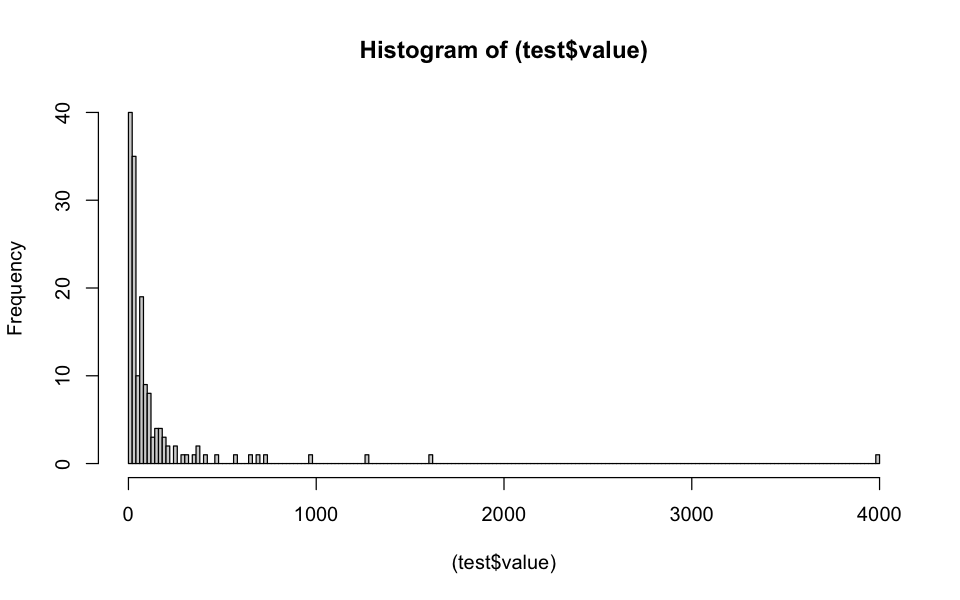

In [64]:
## Need to work out some kind of ADT filtering strategy as the ADTs fail to converge. Some assumptions are broken. 
## Variance is too high to estimate changes for mean expression. 
#Calcuate Variance over Mean (too high indicates that the expression is low and variance is too high)
library(EnvStats) #Load outlier library
test <- (rowVars(as.matrix(counts_ADT_filt))/ rowMeans(counts_ADT_filt)  ) %>% as_tibble(rownames = "gene") %>% arrange(-value)
hist((test$value), breaks = length(test$value)) #estimate outliers based on distributions

In [65]:
#set K
outliers <- rosnerTest(test$value, k = 4) %>% with(all.stats) %>% with(Obs.Num) #identify outliers with rosnerTest
genes <- test$gene[-outliers] # remove outliers

In [66]:
# Linear model including a random effect for plate. (lmer)
#Subset Exprs (normalized for lmer)
## In this example, PCS are hurting me. 
###CD86 and HLA are not modeling well. the deviance is too high. Let's remove and try again. 

df <- CD45Plots2
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- counts_ADT_filt[, df$cell]
gene <- intersect(genes, rownames(Exprs))#defined above on variance to mean ratio
gene <- genes[-grep(genes, pattern = "^Ig")] #Remove Ig genes

Exprs %>% dim

suppressMessages({
    suppressWarnings({
CD45_lm_Dosage_adt <- 
    sapply(gene, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + Plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + Plate + Individual_Index + Dosage, 
               )
     return(c(coefficients(lm1), "pval" = anova(lm0,lm1, test = "Chisq")[2,8]))
        })
    })
    })

CD45_lm_Dosage_adt<- 
    t(CD45_lm_Dosage_adt) %>% 
    as_tibble(rownames = "gene") %>% 
    mutate(padjBH = p.adjust(pval, method = "BH"))

.
  0   1   2 
239 148 165 

[1] 154 552

In [67]:
CD45_lm_Dosage_adt %>% write_csv("CD45_lm_Dosage_adt.csv")

In [68]:
CD45_lm_Dosage_adt %>% arrange(padjBH,Dosage) %>% filter(padjBH < 0.05)

gene             (Intercept) log10(nUMI.x) PlateP3     PlateP4     
1  CD45              -2.0468482 1.4771486      0.41036020  0.569342794
2  CD45RO            -1.7657936 1.8603325      0.14813317  0.156528715
3  CD45RA            -3.0252075 1.4001527      0.24206425  0.177409090
4  CD4               -3.9610630 2.0243146      0.12519039  0.079133912
5  CD37              -7.6614847 2.6335069     -0.10226631 -0.009083931
6  CD88              -6.7863303 2.6436741     -0.11697028 -0.065562021
7  CD183             -4.8101715 2.1813712     -0.04222950 -0.095342699
8  CD73              -3.9833873 1.9477242      0.11702898  0.064934302
9  CD69              -5.7982608 2.1999891      0.01840056 -0.066205035
10 CD134             -3.7626462 2.2755862      0.06733781  0.001704580
11 CD28              -6.9999581 2.2589790     -0.24775246 -0.211978577
12 CD8               -9.1736578 2.5839882      0.07228675 -0.315595327
13 HLADR             -9.5365186 3.0953408      0.05084661  0.307837519
14 CD56              -3.7991016 1.2602036      0.64674602  0.712220988
15 CD279             -1.6679000 2.1541045      0.06195883  0.043249304
16 CD101             -6.1372951 1.9188044      0.25071465  0.377984194
17 CD58              -4.7107131 2.3180728      0.01819027  0.028741869
18 CD150             -2.6811681 1.7883916      0.17697303  0.176861828
19 CD18              -4.7300747 1.6423049      0.18922530  0.027914798
20 CD26              -4.3167274 1.8571870      0.33452321  0.452000874
21 CD192             -6.2354597 2.2364004     -0.05003525 -0.022446486
22 CD57_Recombinant   0.0693149 0.2094966      1.80258644  1.181028376
23 CD137             -7.1823631 2.6192152      0.03663056  0.272632163
24 CD11a             -4.8895010 1.8084702      0.24469666  0.210326100
25 CD22             -10.1205654 2.8381565     -0.23211557 -0.003530558
26 CD25              -3.3913866 1.9361609      0.23000979  0.218585243
27 CD23              -5.8719976 2.1093287      0.03168850  0.050287900
28 CD223             -3.4198078 2.5807192      0.03243125 -0.074661598
29 CD109             -3.7294136 1.9913220      0.30802524  0.194049213
30 Integrin_β7       -3.8562968 1.8623817      0.18682565 -0.060850247
31 CD81              -6.3529854 2.2826486      0.03358285  0.037268097
32 CD142             -6.0774351 2.3816490      0.04232024  0.019529377
   Individual_Index10038222 Individual_Index10049338 Dosage      pval        
1  -0.0610178144            -0.270423224             -0.79188074 0.000000e+00
2  -0.1581023213            -0.168991591             -0.65251137 0.000000e+00
3   0.1273746385             0.053501902             -0.50128760 0.000000e+00
4   0.1119169093            -0.191678343              0.28395588 0.000000e+00
5  -0.0435137567            -0.097993958              0.12989001 1.443963e-09
6  -0.0929159757            -0.082648357              0.08966835 2.643978e-07
7  -0.1761880437             0.108472612              0.11316648 2.938164e-06
8   0.2594278971             0.345087557             -0.30238449 4.988169e-06
9  -0.3085758182             0.092251846             -0.26658082 5.363573e-06
10 -0.0951766483             0.140529802             -0.12302750 4.155500e-06
11 -0.0950108039            -0.215938406              0.17101937 4.907703e-06
12 -0.0349634131             0.168129213             -0.35176601 7.503447e-06
13  0.3124981611             0.016860541             -0.22827860 9.530766e-06
14  0.4867834998            -0.010298534             -0.27505628 2.826329e-05
15  0.2023847378             0.231775334             -0.11260116 1.277803e-04
16  0.1082445900             0.422780123              0.15435505 1.954125e-04
17  0.0419626313            -0.050344758              0.04002109 2.275587e-04
18  0.0245589810             0.004398234              0.06731778 2.196204e-04
19  0.1722111680            -0.169784707              0.13362493 4.458810e-04
20 -0.0210075164             0.470712807              0.19758670 6.452466e-04
21 -0.0004645872      

In [70]:
# Linear model including a random effect for plate. (lmer)
#Subset Exprs (normalized for lmer)
## In this example, PCS are hurting me. 
###CD86 and HLA are not modeling well. the deviance is too high. Let's remove and try again. 

df <- CD45Plots3
df$Individual_Index <- as.factor(df$Individual_Index)
df$Dosage %>% table
Exprs <- counts_ADT_filt[, df$cell]
gene <- intersect(genes, rownames(Exprs))#defined above on variance to mean ratio
gene <- genes[-grep(genes, pattern = "^Ig")] #Remove Ig genes

Exprs %>% dim

suppressMessages({
    suppressWarnings({
CD45_lm_Edited_adt <- 
    sapply(genes, function(i){ 
        

    lm0<- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1 + log10(nUMI.x) + Plate + Individual_Index, 
            )
    
    lm1 <- glm.nb(data = df,  
          formula = (Exprs)[i,] ~ 1  + log10(nUMI.x) + Plate + Individual_Index + Edited_Index, 
               )
     return(c(coefficients(lm1), "pval" = anova(lm0,lm1, test = "Chisq")[2,8]))
        })
    })
    })

CD45_lm_Edited_adt<- 
    t(CD45_lm_Edited_adt) %>% 
    as_tibble(rownames = "gene") %>% 
    mutate(padjBH = p.adjust(pval, method = "BH"))

.
  0   1   2 
282 148 165 

[1] 154 595

In [71]:
CD45_lm_Edited_adt %>% write_csv("CD45_lm_Edited_adt.csv")

## Differential Gene and Protein Combination.

In [642]:
"#91003F","#DF65B0" , "#C994C7"

ERROR: Error in parse(text = x, srcfile = src): <text>:1:10: unexpected ','
1: "#91003F",
             ^


In [645]:
CD45_lm_Dosage %>% filter(padjBH < 0.05) %>% arrange(-pval) %>% head(1) %>% with(pval)

[1] 3.016147e-06

Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


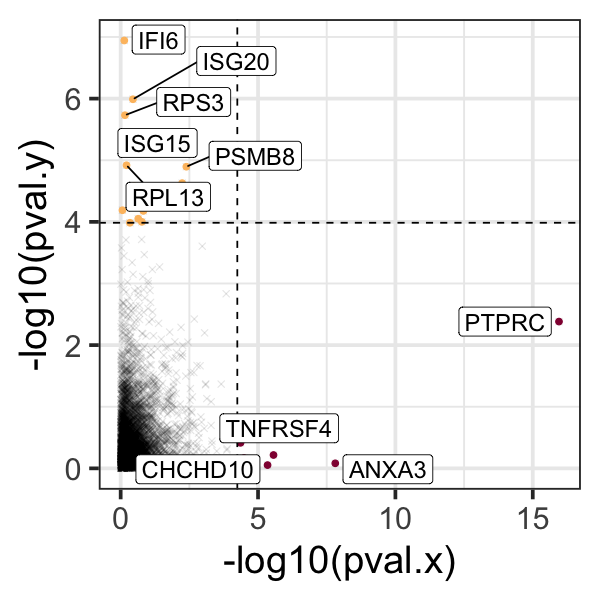

In [800]:
fig.size(5,5)
inner_join(CD45_lm_Dosage  %>% mutate(Condition = "Dosage"),
CD45_lm_Edited %>% mutate(Condition = "Edited"), by = "gene") %>% 

{
ggplot(data = ., aes(-log10(pval.x), -log10(pval.y))) + 
    geom_point(alpha = 0.1, shape = 4)+
    geom_point(data = filter(`.`, padjBH.x < 0.05), color = "#91003F") +
     geom_point(data = filter(`.`, padjBH.y < 0.05), color = "#FDBF6E") +
    theme_gy() + 
    geom_vline(xintercept = -log10( 
    CD45_lm_Dosage %>% filter(padjBH < 0.05) %>% arrange(-pval) %>% head(1) %>% with(pval)
    ), linetype = 2) + 
    geom_hline(yintercept =  -log10( 
    CD45_lm_Edited %>% filter(padjBH < 0.05) %>% arrange(-pval) %>% head(1) %>% with(pval)
    ), linetype = 2) + 
    geom_label_repel(data = filter(`.`, padjBH.x < 0.01), aes(label = gene), size  =5) +
     geom_label_repel(data = filter(`.`, padjBH.y < 0.05), aes(label = gene), size  =5)
    
    }

Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call

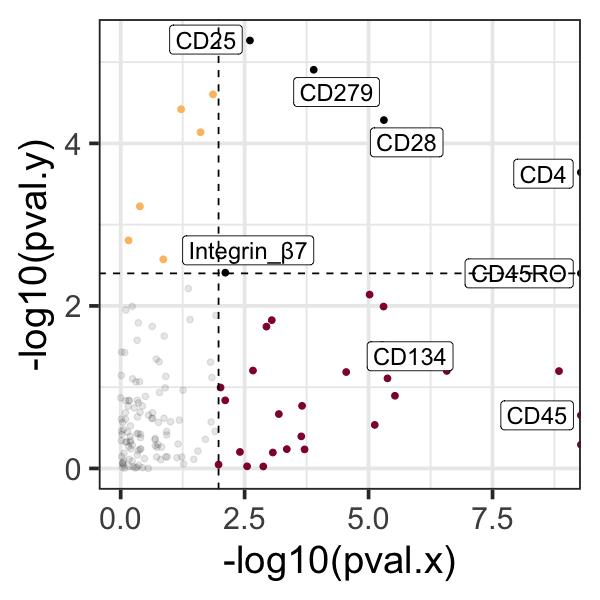

In [801]:
fig.size(5,5)
inner_join(CD45_lm_Dosage_adt  %>% mutate(Condition = "Dosage"),
CD45_lm_Edited_adt %>% mutate(Condition = "Edited"), by = "gene") %>% 

{
ggplot(data = ., aes(-log10(pval.x), -log10(pval.y)))  +
    geom_point(alpha = 0.1)+
    geom_point(data = filter(`.`, padjBH.x < 0.05 & padjBH.y > 0.05), color = "#91003F") +
     geom_point(data = filter(`.`, padjBH.y < 0.05 & padjBH.x > 0.05), color = "#FDBF6E") +
    geom_point(data = filter(`.`, padjBH.y < 0.05 & padjBH.x < 0.05), color = "black")+
    theme_gy()+
     #geom_label_repel(data = filter(`.`, padjBH.x < 0.05 & padjBH.y > 0.05), aes(label = Gene)) +
     #geom_label_repel(data = filter(`.`, padjBH.y < 0.05 & padjBH.x > 0.05), aes(label = Gene)) + 
     geom_label_repel(data = filter(`.`, padjBH.y < 0.05 & padjBH.x < 0.05), aes(label = gene), size  =5) +
    geom_vline(xintercept = -log10( 
    CD45_lm_Dosage_adt %>% filter(padjBH < 0.05) %>% arrange(-pval) %>% head(1) %>% with(pval)
    ), linetype = 2) + 
    geom_hline(yintercept =  -log10( 
    CD45_lm_Edited_adt %>% filter(padjBH < 0.05) %>% arrange(-pval) %>% head(1) %>% with(pval)
    ), linetype = 2) + 
    geom_label_repel(data = filter(`.`,gene == "CD45"), aes(label = gene), size  =5)+ 
    geom_label_repel(data = filter(`.`,gene == "CD134"), aes(label = gene), size  =5)
    
    }

In [783]:
#Function for creating heatmap plots of significant genes from scaled exprs 
##Define gene set. 
sig_genes_Dosage <- CD45_lm_Dosage %>% filter(padjBH < 0.05) %>% top_n(5, wt=-pval) %>% with(gene) # select top 5
sig_genes_Edited<- CD45_lm_Edited %>% filter(padjBH < 0.05) %>% top_n(5, wt=-pval) %>%  with(gene) # select top 5
sig_genes <- union(sig_genes_Dosage,sig_genes_Edited)
#Scale data
scale_exprs <- exprs %>% normalizeData(method = "log") %>% scaleData()

#Pull out data and pivot longer. 
df<- CD45Plots3 %>% filter(Edited_Index == "Edited") %>% 
    mutate(group = paste0(Dosage,"_", Individual_Index)) %>% 
    dplyr::select(cell, group) %>% 
    inner_join(t(scale_exprs[sig_genes, CD45Plots3$cell]) %>%
                   as_tibble(rownames = "cell")) %>% 
    group_by(group) %>% 
    summarise_all(.funs = mean) %>% 
    dplyr::select(-cell) %>% 
    pivot_longer(-group) 

df2 <- CD45Plots3 %>%
    mutate(group = paste0(Edited_Index,"_", Individual_Index)) %>%
    dplyr::select(cell, group) %>% 
    inner_join(t(scale_exprs[sig_genes, CD45Plots3$cell]) %>%
                   as_tibble(rownames = "cell")) %>% 
    group_by(group) %>% 
    summarise_all(.funs = mean) %>% 
    dplyr::select(-cell) %>% 
    pivot_longer(-group) 

#rename dfs
colnames(df) <- c("X", "gene", "value")
colnames(df2) <- c("X", "gene", "value")

#Order geneset
test <- scale_exprs[sig_genes_Dosage, CD45Plots3$cell] %>% dist %>% hclust
test2 <- scale_exprs[sig_genes_Edited, CD45Plots3$cell] %>% dist %>% hclust
order <- union(sig_genes_Dosage[test$order], sig_genes_Edited[test2$order])

Joining with `by = join_by(cell)`
Warning message:
“There were 9 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cell = (new("standardGeneric", .Data = function (x, ...) ...`.
ℹ In group 1: `group = "0_10020543"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Joining with `by = join_by(cell)`
Warning message:
“There were 6 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cell = (new("standardGeneric", .Data = function (x, ...) ...`.
ℹ In group 1: `group = "Control_10020543"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”


Saving 7 x 7 in image


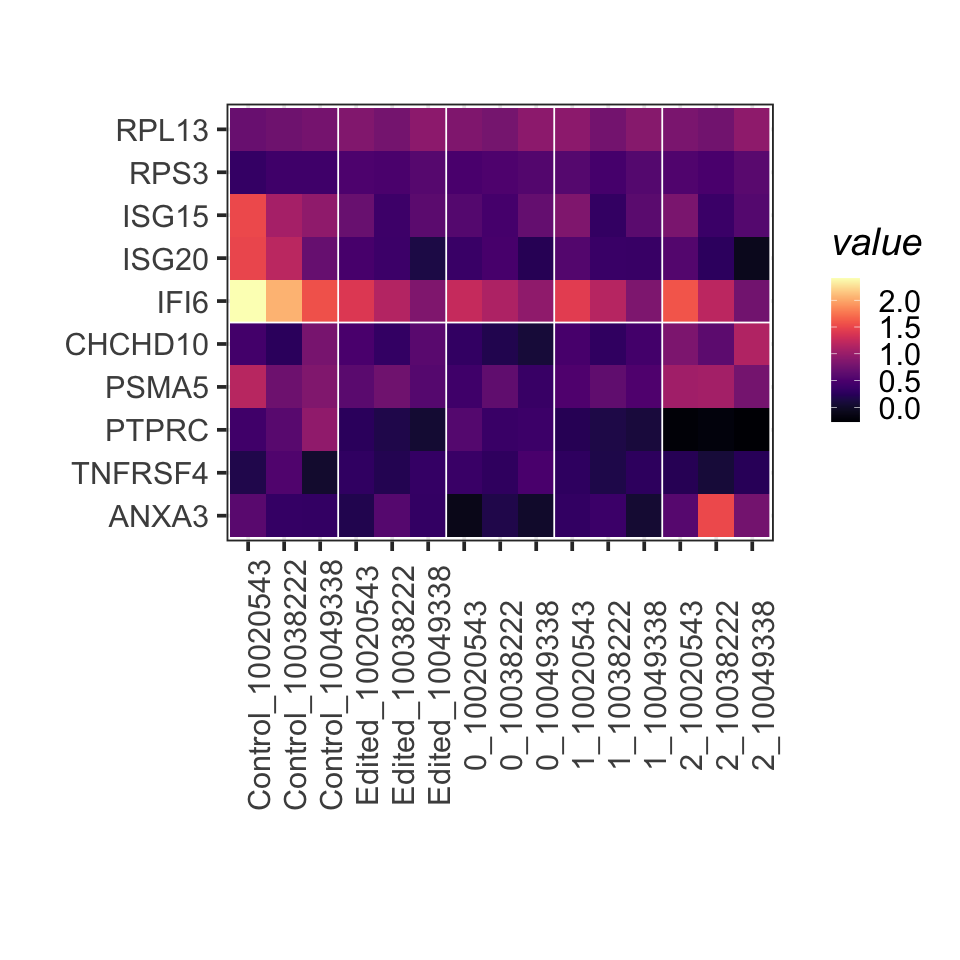

In [802]:
#Plot Figure
fig.size(8,8)
g<-  ggplot() + 
geom_tile(data = df,
          aes(x = X, y = gene, fill = value)) + 
geom_tile(data = df2,
          aes(x = X, y = gene, fill = value)) + 
scale_fill_viridis(option = "magma") + 
theme_gy() + 
scale_y_discrete(limits = c(order)) + 
theme(axis.text.x = element_text(angle = 90)) + 
scale_x_discrete(limits = c(unique(df2$X),unique(df$X))) + 
theme(legend.position = "right") + 
geom_vline(xintercept = c(3.5, 6.5, 9.5,12.5,15.5), color = "white")+
geom_hline(yintercept = sum(sig_genes %in% sig_genes_Dosage)+0.5, color = "white") + 
xlab("") + ylab("")+ 
theme(aspect.ratio = 0.8)

plot(g)
## save the plot
suppressWarnings({ 
    ggsave(g, filename = "g.png", device = "png", dpi = 300)
    })

In [ ]:
## Exact same analysis, but with adt

In [659]:
#Extract ADTs
sig_genes_Dosage_adt <- CD45_lm_Dosage_adt %>% filter(padjBH < 0.05) %>% top_n(wt = -pval, n = 5) %>% with(gene)
sig_genes_Edited_adt<- CD45_lm_Edited_adt %>% filter(padjBH < 0.05) %>% top_n(wt = -pval,n = 5) %>% with(gene)

## gotta manually filter some ADTs that don't make sense. 
sig_genes_Dosage_adt<-
sig_genes_Dosage_adt[!grepl(sig_genes_Dosage_adt, pattern = "Ig")]
sig_genes_Edited_adt <- sig_genes_Edited_adt[!grepl(sig_genes_Edited_adt, pattern = "Ig")]
sig_genes_adt <- union(sig_genes_Dosage_adt,sig_genes_Edited_adt)

#Assign Ordering 
test <- scale_adt[sig_genes_Dosage_adt, CD45Plots3$cell] %>% dist %>% hclust
test2 <- scale_adt[sig_genes_Edited_adt, CD45Plots3$cell] %>% dist %>% hclust
order_adt <- union(sig_genes_Dosage_adt[test$order], sig_genes_Edited_adt[test2$order])

#Define data sets
df_adt<- CD45Plots3 %>% filter(Edited_Index == "Edited") %>% 
    mutate(group = paste0(Dosage,"_", Individual_Index)) %>% 
    dplyr::select(cell, group) %>% 
    inner_join(t(scale_adt[sig_genes_adt, CD45Plots3$cell]) %>%
                   as_tibble(rownames = "cell")) %>% 
    group_by(group) %>% 
    summarise_all(.funs = mean) %>% 
    dplyr::select(-cell) %>% 
    pivot_longer(-group) 

df2_adt <- CD45Plots3 %>%
    mutate(group = paste0(Edited_Index,"_", Individual_Index)) %>%
    dplyr::select(cell, group) %>% 
    inner_join(t(scale_adt[sig_genes_adt, CD45Plots3$cell]) %>%
                   as_tibble(rownames = "cell")) %>% 
    group_by(group) %>% 
    summarise_all(.funs = mean) %>% 
    dplyr::select(-cell) %>% 
    pivot_longer(-group) 

colnames(df_adt) <- c("X", "gene", "value")
colnames(df2_adt) <- c("X", "gene", "value")

Joining with `by = join_by(cell)`
Warning message:
“There were 9 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cell = (new("standardGeneric", .Data = function (x, ...) ...`.
ℹ In group 1: `group = "0_10020543"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 8 remaining warnings.”
Joining with `by = join_by(cell)`
Warning message:
“There were 6 warnings in `summarise()`.
The first warning was:
ℹ In argument: `cell = (new("standardGeneric", .Data = function (x, ...) ...`.
ℹ In group 1: `group = "Control_10020543"`.
Caused by warning in `mean.default()`:
! argument is not numeric or logical: returning NA
ℹ Run `dplyr::last_dplyr_warnings()` to see the 5 remaining warnings.”


In [797]:
#adjust order of ADT because of shared. 
order_adt <- c('CD37','CD45RA','CD45','CD45RO','CD4','CD55','CD7','CD25')

In [668]:
df_adt$gene %>% table
df2_adt$gene %>% table

.
  CD25  CD279   CD28   CD37    CD4   CD45 CD45RA CD45RO  CD62L    CD7 
     9      9      9      9      9      9      9      9      9      9 

.
  CD25  CD279   CD28   CD37    CD4   CD45 CD45RA CD45RO  CD62L    CD7 
     6      6      6      6      6      6      6      6      6      6 

In [661]:
max(df_adt$value, df2_adt$vaue)

Warning message:
“Unknown or uninitialised column: `vaue`.”


[1] 0.8266766

Saving 7 x 7 in image


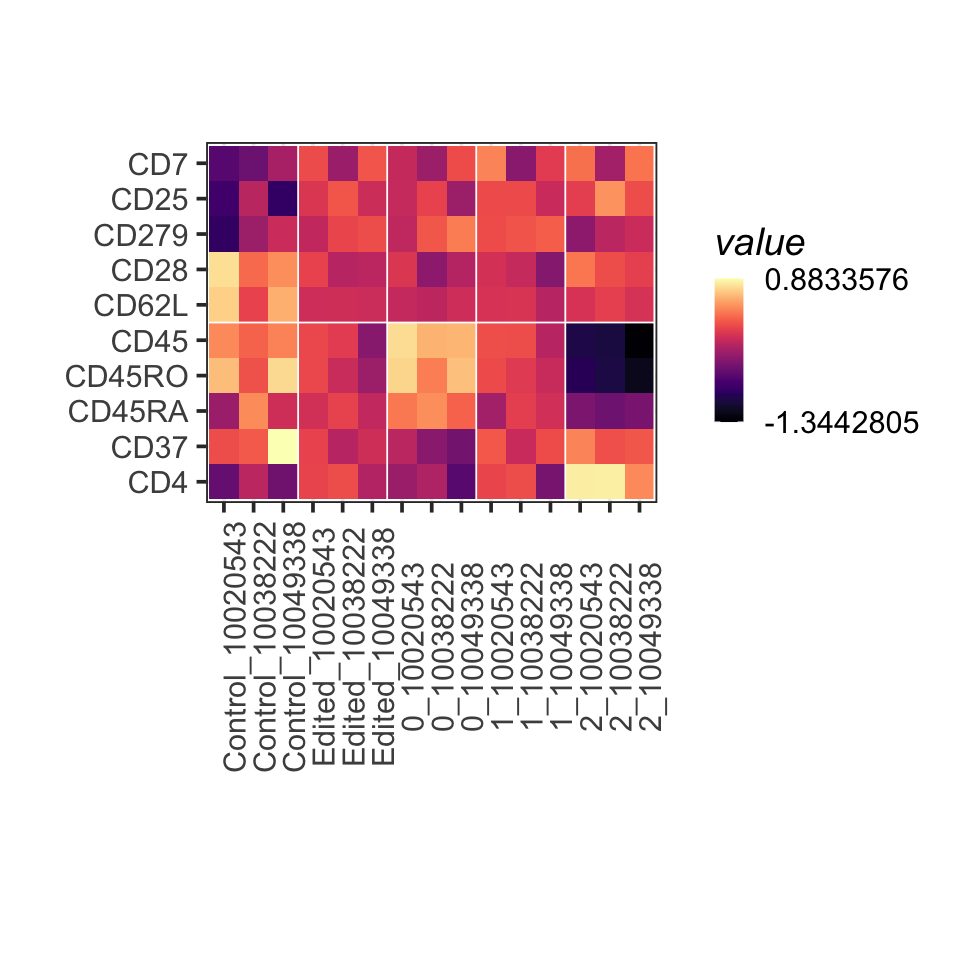

In [803]:
fig.size(8,8)
g <-  ggplot() + 
geom_tile(data = df_adt,
          aes(x = X, y = gene, fill = value)) + 
geom_tile(data = df2_adt,
          aes(x = X, y = gene, fill = value)) + 
scale_fill_viridis(option = "magma", breaks = c(max(df_adt$value, df2_adt$value), min(df_adt$value, df2_adt$value))) + 
theme_gy() + 
scale_y_discrete(limits = c(order_adt)) + 
theme(axis.text.x = element_text(angle = 90)) + 
scale_x_discrete(limits = c(unique(df2_adt$X),unique(df_adt$X))) + 
geom_vline(xintercept = c(3.5, 6.5, 9.5,12.5,15.5), color = "white")+
geom_hline(yintercept = 5.5, color = "white") + 
xlab("") + ylab("") +
  theme(legend.position = "right") + 
theme(aspect.ratio = 0.8)

plot(g)
## save the plot
suppressWarnings({ 
    ggsave(g, filename = "g.png", device = "png", dpi = 300)
    })

Joining with `by = join_by(cell)`


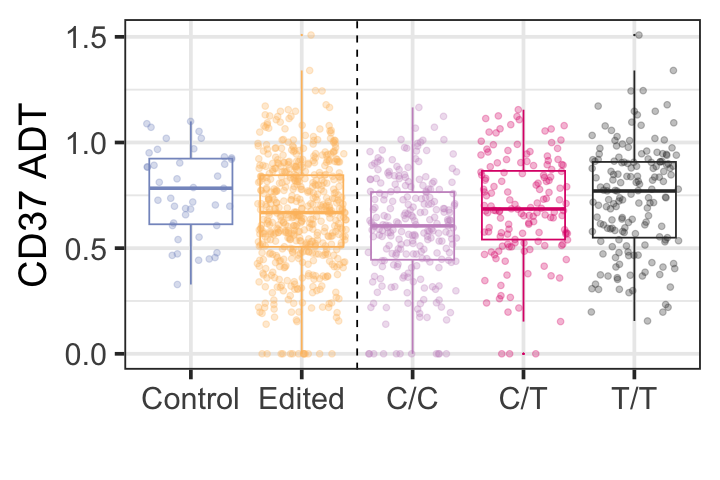

In [845]:
#plot of ADT ands genes across genotypes and conditions
fig.size(4, 6)

norm_adt["CD37",] %>% as_tibble(rownames = "cell") %>% inner_join(CD45Plots3) %>%  
    filter(genotype_count >2) %>% na.omit() %>%
{

ggplot(.) +  
geom_boxplot(outlier.size = 0,
             aes(Edited_Index, `value`, color = Edited_Index)) + 
geom_boxplot(outlier.size = 0, 
             data = . %>% filter(genotype3 != "Control"),
             aes(genotype3, `value`, color = genotype3)) +
geom_jitter(aes(Edited_Index, `value`, color = Edited_Index), 
           alpha = 0.3) + 
geom_jitter(data = . %>% filter(genotype3 != "Control"),
             aes(genotype3, `value`, color = genotype3), 
           alpha = 0.3) + 
theme_gy()+
scale_x_discrete(limits = c("Control", 
                           "Edited", 
                           "C/C",
                           "C/T", 
                           "T/T"
                           )) + 
geom_vline(xintercept = 2.5, linetype = 2) + 
scale_color_manual(values = c(
          "Control" = "#8698C7",
          "Edited" = "#FDBF6E",
          "C/C" = "#C994C7",
          "C/T" = "#DD1C77", 
          "T/T" = "grey20"))+ 
xlab("") + 
ylab("CD37 ADT")+ 
theme(
     # axis.title.y = element_text(face = "italic"),
    legend.position = "none") 
    
} 

## Volacano Plots

In [84]:
CD45_lm_Dosage %>% head

gene   (Intercept) log10(nUMI.y) PlateP3    PlateP4    
1 MT-CO2 -3.5006194  2.130221      -0.1382712  0.01895425
2 MALAT1  0.2594335  1.074377      -0.1108392 -0.01603064
3 TPI1   -6.4686060  2.699072       0.2413221  0.21555403
4 TMSB10 -2.4553364  1.660458      -0.6509961 -0.33865911
5 RPLP0  -4.7499869  2.397953       0.1657264  0.08608635
6 RPL10  -4.0642373  2.128046      -0.2702097 -0.15602620
  Individual_Index10038222 Individual_Index10049338 Dosage      pval        
1 -0.16224820              -0.03200045               0.06022700 0.0190552005
2 -0.36429234              -0.05141699              -0.10926624 0.0063225546
3  0.05884542               0.01123968              -0.03282912 0.1155115471
4 -0.05277669               0.07546562               0.04831342 0.0208905896
5  0.08904630               0.04023906              -0.01874479 0.3397473431
6 -0.09286718              -0.04539214              -0.05280260 0.0008819483
  padjBH   
1 0.3968129
2 0.2791995
3 0.6810422
4 0.4044072
5 0.8293229
6 0.1430838

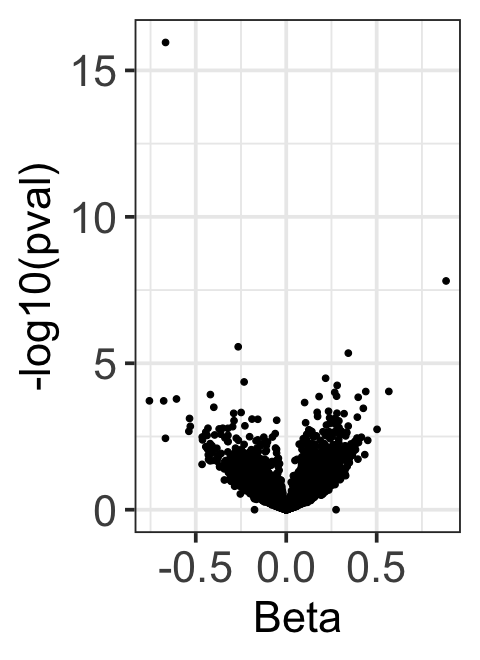

In [90]:
fig.size(5.5)
CD45_lm_Dosage %>% { 
    ggplot(., aes(Dosage, -log10(pval))) + geom_point() } + theme_gy() + xlab("Beta")

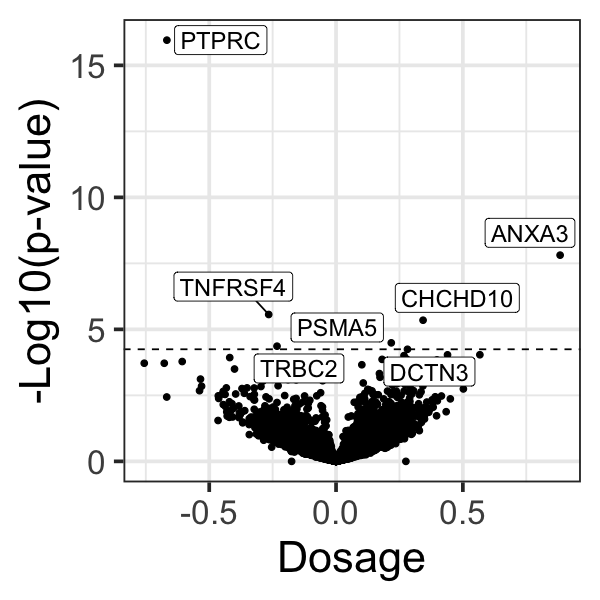

In [108]:
fig.size(5,5)
g <- CD45_lm_Dosage %>% {
ggplot(.) + 
geom_point(aes(Dosage, -log10(pval))) +
theme_gy() +
geom_label_repel(data = . %>% filter(padjBH < 0.05), 
               aes(Dosage, -log10(pval), label = gene), size = 5) + 
theme(legend.position = "none") + 
geom_hline(yintercept = -log10(CD45_lm_Dosage %>% arrange(pval) %>% filter(padjBH < 0.05) %>% tail(1) %>% with(pval)), linetype =2)+ 
ylab("-Log10(p-value)") +
    theme(axis.text.x = element_text(size = 20),
          axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))

}
g

In [112]:
ggsave(g, filename = "g.png", device = "png", width = 5, height = 5)

Warning message:
“ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <ce>”
Warning message in grid.Call(C_textBounds, as.graphicsAnnot(x$label), x$x, x$y, :
“conversion failure on 'Integrin_β7' in 'mbcsToSbcs': dot substituted for <b2>”
Warning message in grid.Call

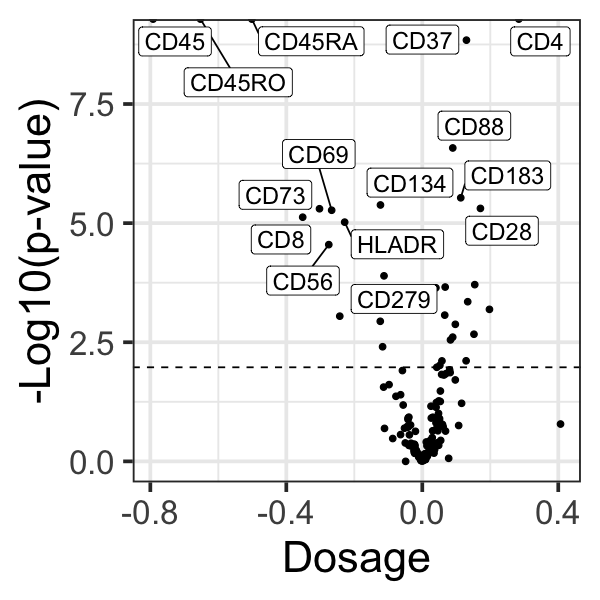

In [111]:
fig.size(5,5)
g <- CD45_lm_Dosage_adt %>% {
ggplot(.) + 
geom_point(aes(Dosage, -log10(pval))) +
theme_gy() +
geom_label_repel(data = . %>% filter(padjBH < 0.05), 
               aes(Dosage, -log10(pval), label = gene), size = 5) + 
theme(legend.position = "none") + 
geom_hline(yintercept = -log10(CD45_lm_Dosage_adt %>% arrange(pval) %>% filter(padjBH < 0.05) %>% tail(1) %>% with(pval)), linetype =2)+ 
ylab("-Log10(p-value)") +
    theme(axis.text.x = element_text(size = 20),
          axis.text.y = element_text(size = 20),
          strip.text = element_blank(), 
         panel.spacing = unit(1, "lines"))

}
g